### imports 

In [1]:
import os
from os import path
import configparser
from github import Github
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import datetime
from datetime import datetime
from datetime import timezone
from ast import literal_eval
import requests
from requests.adapters import HTTPAdapter, Retry

In [2]:
import githubanalysis.processing.repo_name_clean as name_clean
import githubanalysis.processing.get_repo_connection as ghconnect
import githubanalysis.processing.setup_github_auth as ghauth
import githubanalysis.processing.get_all_pages_issues as getallissues
import githubanalysis.processing.get_issue_assignees as get_assignee
import githubanalysis.analysis.calc_days_since_repo_creation as dayssince
import githubanalysis.processing.summarise_repo_stats
from githubanalysis.processing.summarise_repo_stats import RepoStatsSummariser
import utilities.get_default_logger as loggit
import utilities.chunker as chunker

### access token 

In [3]:
# set up github access token with github package: 

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']
g = Github(access_token) 

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {f"Authorization: Bearer {gh_token}"}

## Big20Top10 Repos

In [7]:
repo_list = [
    'Dallinger/Dallinger',
    'Axelrod-Python/Axelrod',
    'CICE-Consortium/CICE',
    'MPAS-Dev/compass',
    'kinverarity1/lasio',
    'astrorama/SourceXtractorPlusPlus',
    'CICE-Consortium/Icepack',
    'NOAA-GFDL/MDTF-diagnostics',
    'uwescience/pulse2percept',
    'JeschkeLab/DeerLab'
    ]
#print(repo_list)

In [4]:
# get stats from gh_stats for big20top10: 
gh_stats = pd.read_csv('../../data/gh_stats_2024-02-14.csv', header=0)
gh_stats

,repo_name,initial_HTTP_code,issues_enabled,repo_is_fork,devs,total_commits_last_year,has_PRs,last_PR_update,open_tickets,closed_tickets,repo_age_days,repo_license,repo_visibility,repo_language
0,leonmhartman/Gnotobiotic_E.diaphana,200,True,False,1.0,0.0,False,NaN,0.0,0.0,975.0,NaN,True,"dict_keys(['R', 'Shell'])"
1,ProyectoAether/Aether-Portal,200,True,False,5.0,33.0,True,2023-11-30 11:57:40+00:00,0.0,34.0,336.0,MIT,True,"dict_keys(['Svelte', 'Python', 'TypeScript', '..."
2,MotionbyLearning/stm,200,True,False,6.0,109.0,True,2024-01-15 17:37:06+00:00,15.0,46.0,478.0,Apache-2.0,True,"dict_keys(['Jupyter Notebook', 'Python'])"
3,nicolasfara/reconfiguration-experiments,200,True,False,3.0,216.0,True,2024-02-12 13:21:54+00:00,0.0,109.0,148.0,Apache-2.0,True,"dict_keys(['Jupyter Notebook', 'Scala', 'Kotli..."
4,ashleefv/CFDparticleLungMucosa,200,True,False,1.0,12.0,False,NaN,0.0,0.0,284.0,BSD-3-Clause,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,cwarriner/warriner_etal_2022,200,True,False,1.0,0.0,False,NaN,0.0,0.0,575.0,NaN,True,dict_keys(['MATLAB'])
1872,CuckooWang/iFPS,200,True,False,1.0,0.0,True,2020-10-02 01:27:25+00:00,0.0,2.0,1303.0,Apache-2.0,True,"dict_keys(['Java', 'Python'])"
1873,JacquesCarette/Drasil,200,True,False,46.0,842.0,True,2024-02-07 17:15:23+00:00,376.0,3259.0,3447.0,BSD-2-Clause,True,"dict_keys(['Haskell', 'Makefile', 'Shell', 'Py..."
1874,OSU-BMBL/Spinal-cord-scRNAseq,200,True,False,1.0,0.0,False,NaN,0.0,0.0,735.0,NaN,True,"dict_keys(['HTML', 'R'])"


In [5]:
count404s = len(gh_stats.loc[gh_stats['initial_HTTP_code'] != 200])
gh_stats = gh_stats.loc[gh_stats['initial_HTTP_code'] == 200]

gh_stats['has_issues'] = np.where((gh_stats['open_tickets'] > 1) | (gh_stats['closed_tickets'] > 1), True, False)
gh_stats['all_tickets'] = (gh_stats['open_tickets'] + gh_stats['closed_tickets'])
gh_stats['uses_both'] = np.where((gh_stats['has_issues'] is True) and (gh_stats['has_PRs'] is True), True, False)
len(gh_stats.index)

/tmp/ipykernel_589365/1618769183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gh_stats['has_issues'] = np.where((gh_stats['open_tickets'] > 1) | (gh_stats['closed_tickets'] > 1), True, False)
/tmp/ipykernel_589365/1618769183.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gh_stats['all_tickets'] = (gh_stats['open_tickets'] + gh_stats['closed_tickets'])
/tmp/ipykernel_589365/1618769183.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

1823

False

In [194]:
#    # read in csv file of repo urls generated by zenodocode/get_gh_repo_dataset.py
    # count input repo urls
    
print(gh_stats.columns)

Index(['repo_name', 'initial_HTTP_code', 'issues_enabled', 'repo_is_fork',
       'devs', 'total_commits_last_year', 'has_PRs', 'last_PR_update',
       'open_tickets', 'closed_tickets', 'repo_age_days', 'repo_license',
       'repo_visibility', 'repo_language', 'has_issues', 'all_tickets'],
      dtype='object')


In [ ]:
#eligible_repos = []
    
    # devs: devs > 6  
    # issues_enabled = True
    # repo_is_fork = False 
    # has_PRs = True  
    # has_issues = True
    #accept_languages = ['Python', 'C', 'C++', 'Shell', 'Fortran', '']
    
#acceptedlingos = ['Python', 'C', 'C++', 'Shell', 'Fortran']


# summarise stats using: summarise_repo_stats(repo_name):

            # count number of devs

            # count number of commits

            # count closed issue tickets

            # get date of last commit

            # get age of repo

            # get license type

            # is repo accessible?

            # does repo contain code
            # repo languages include: python, (C, C++), (shell?, R?, FORTRAN?)

            # ? repo architecture?


        # check eligibility of each repo using: check_repo_eligibility(repo_name)

        # collate eligible repos, discard ineligible ones.

    # count eligible repos total

    # output eligible repos

In [5]:
# need to get proportion of assignment data for items for each of the ~1800 repos


import githubanalysis.processing.get_all_pages_issues
from githubanalysis.processing.get_all_pages_issues import IssueGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_NOTEBOOK_logs.txt')  
issues_getter = IssueGetter(logger)

import githubanalysis.processing.get_repo_contributors
from githubanalysis.processing.get_repo_contributors import DevsGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_repo_contributors_NOTEBOOK_logs.txt')  
devs_getter = DevsGetter(logger)

repo_list_full_sample = gh_stats.loc[gh_stats['has_issues'] == True]['repo_name']
len(repo_list_full_sample) #559 matches has_issues plot number. Good.

repo_list_full_sample[0:10]


#testrepo = gh_stats.loc[gh_stats['repo_name']=='famuvie/geoRcb']

for item in repo_list_full_sample:
    sanitised_repo_name = item.replace("/", "-")
    iss_df = issues_getter.get_all_pages_issues(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
    devs_df = devs_getter.get_repo_contributors(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')

# # fails: 'login'
# 'famuvie/geoRcb'
#iss_df = issues_getter.get_all_pages_issues(repo_name='AtmosFOAM/AtmosFOAM-tools', config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
# # works:
#iss_df = issues_getter.get_all_pages_issues(repo_name="JeschkeLab/DeerLab", config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
# iss_df

INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 3 anonymous contributors for repo ProyectoAether/Aether-Portal.
INFO:Total number of contributors grabbed is 6 in 1 page(s).
INFO:There are 3 anonymous contributors for repo MotionbyLearning/stm.
INFO:>> Running issue grab for repo nicolasfara/reconfiguration-experiments, in page 1 of 2.
INFO:>> Running issue grab for repo nicolasfara/reconfiguration-experiments, in page 2 of 2.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo nicolasfara/reconfiguration-experiments.
INFO:>> Running issue grab for repo bihealth/altamisa, in page 1 of 2.
INFO:>> Running issue grab for repo bihealth/altamisa, in page 2 of 2.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo bihealth/altamisa.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 1 anonymous contributors for repo FIoT-Clien

INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 56 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 57 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 58 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 59 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 60 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 61 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 62 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 63 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 64 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 65 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 66 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 67 of 170.
INFO:>> Running issue grab for repo swso

INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 158 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 159 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 160 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 161 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 162 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 163 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 164 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 165 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 166 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 167 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 168 of 170.
INFO:>> Running issue grab for repo swsoyee/2019-ncov-japan, in page 169 of 170.
INFO:>> Running issue grab f

INFO:There are 0 anonymous contributors for repo mcfrith/tandem-genotypes.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo discos/discos-backend.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 0 anonymous contributors for repo acdh-oeaw/spacyapp.
INFO:Total number of contributors grabbed is 6 in 1 page(s).
INFO:There are 2 anonymous contributors for repo EnviroDIY/SensorModbusMaster.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo SouthAfricaDigitalScience/readline-deploy.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 3 anonymous contributors for repo hnunner/nidm-simulation.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo gnzng/xaspy.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 0 anonymous contributors for repo R

INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo swlogiclab/multisem.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo BeBOP-OBON/miop.
INFO:Total number of contributors grabbed is 14 in 1 page(s).
INFO:There are 7 anonymous contributors for repo TACC/launcher.
INFO:>> Running issue grab for repo pvermees/IsoplotR, in page 1 of 3.
INFO:>> Running issue grab for repo pvermees/IsoplotR, in page 2 of 3.
INFO:>> Running issue grab for repo pvermees/IsoplotR, in page 3 of 3.
ERROR:Something failed in getting issues for repo pvermees/IsoplotR: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 3 anonymous contributors for repo pvermees/IsoplotR.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo 

INFO:There are 0 anonymous contributors for repo dhondta/peid.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 1 anonymous contributors for repo alon-albalak/TLiDB.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo gewitterblitz/may19_2013_obs_analysis.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo eflows4hpc/software-catalog.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo USEPA/IO-Model-Builder.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo sidmohite/nimbus-astro.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo yyoshiaki/NMFprojection.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo adrn/T

INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 3 anonymous contributors for repo RichRast/Ge3Net.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 3 anonymous contributors for repo slimgroup/GCS-CAM.
INFO:Total number of contributors grabbed is 27 in 1 page(s).
INFO:There are 13 anonymous contributors for repo CloudBindle/Bindle.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo thesketh/pygen-structures.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 2 anonymous contributors for repo deinal/jec-pipeline.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 2 anonymous contributors for repo MoMEMta/MoMEMta-MaGMEE.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo LouisBouvier/InventoryRoutingLNS.jl.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
IN

INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 61 of 64.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 62 of 64.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 63 of 64.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 64 of 64.
INFO:Total number of contributors grabbed is 30 in 1 page(s).
INFO:There are 3 anonymous contributors for repo Dallinger/Dallinger.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 2 anonymous contributors for repo GregGuerin/biomap.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 2 anonymous contributors for repo SarderLab/Histo-cloud.
INFO:>> Running issue grab for repo usnistgov/alignn, in page 1 of 2.
INFO:>> Running issue grab for repo usnistgov/alignn, in page 2 of 2.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo usnistgov/alignn.
INFO:Total number of contributors grab

INFO:Total number of contributors grabbed is 11 in 1 page(s).
INFO:There are 5 anonymous contributors for repo molssi-seamm/lammps_step.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo robitalec/irg.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 3 anonymous contributors for repo BenediktHeinrichs/metadataextractor.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo McSCert/Reach-Coreach.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo TorkamaniLab/zoish.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 3 anonymous contributors for repo ChristianMarzahl/EIPH_WSI.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 1 anonymous contributors for repo mrghg/py12box_invert.
INFO:Total number of contributors grabbed is 1 in 1 page(s)

INFO:There are 2 anonymous contributors for repo luc-girod/MicMacWorkflowsByLucGirod.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo aetherAI/whole-slide-cnn.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
ERROR:Something failed in getting contributors for repo rspatialdata/rspatialdata.github.io: 'login'
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 0 anonymous contributors for repo PSL-Chartes-HTR-Students/HN2021-Kovalewsky-1893.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo simonwmatthews/pyMelt_multinest.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 0 anonymous contributors for repo ndmallmann/urutau.
INFO:Total number of contributors grabbed is 10 in 1 page(s).
INFO:There are 8 anonymous contributors for repo mjoppich/bioGUI.
INFO:Total number of contributors grabbed is 1 in 1 page(

INFO:There are 3 anonymous contributors for repo bauer-alex/APCtools.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo sintefmath/JutulDarcy.jl.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 1 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 2 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 3 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 4 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 5 of 5.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo JeschkeLab/DeerLab.
INFO:Total number of contributors grabbed is 8 in 1 page(s).
INFO:There are 5 anonymous contributors for repo dssg/peeps-chili.
INFO:>> Running issue grab for repo CCBR/CARLISLE, in page 1 of 2.
INFO:>> Running issue grab for repo CCBR/CARLISLE, in page 2 of 2.
INFO:Total number of contributors grabbed 

INFO:There are 0 anonymous contributors for repo laurabiggins/Shiny_omics.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 1 anonymous contributors for repo briandfoy/business-ismn.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 2 anonymous contributors for repo osirrc/elastirini-docker.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 0 anonymous contributors for repo inbo/effectclass.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 3 anonymous contributors for repo elodiegermani/SAPHIR.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 0 anonymous contributors for repo wildlifeevoeco/WildPigSpatiotemporalCompetition.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 0 anonymous contributors for repo scikit-tda/DREiMac.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 1 anonymous contributors for 

INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo whythawk/whyqd.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 1 anonymous contributors for repo lindnemi/understandingemissionprofiles.
INFO:Total number of contributors grabbed is 6 in 1 page(s).
INFO:There are 2 anonymous contributors for repo saltastro/pyhrs.
INFO:Total number of contributors grabbed is 3 in 1 page(s).
INFO:There are 1 anonymous contributors for repo ropensci/mctq.
INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo ctsit/auto_populate_fields.
INFO:Total number of contributors grabbed is 43 in 1 page(s).
INFO:There are 9 anonymous contributors for repo firedrakeproject/fiat.
INFO:>> Running issue grab for repo ExplorViz/explorviz-backend, in page 1 of 2.
INFO:>> Running issue grab for repo ExplorViz/explorviz-backend, in page 2 of 2.
INFO:Total number of contributors grab

INFO:>> Running issue grab for repo yaml2sbml-dev/yaml2sbml, in page 1 of 2.
INFO:>> Running issue grab for repo yaml2sbml-dev/yaml2sbml, in page 2 of 2.
INFO:Total number of contributors grabbed is 5 in 1 page(s).
INFO:There are 0 anonymous contributors for repo yaml2sbml-dev/yaml2sbml.
INFO:Total number of contributors grabbed is 2 in 1 page(s).
INFO:There are 1 anonymous contributors for repo MAnalytics/akmedoids.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo unicus-skmk/test.
INFO:Total number of contributors grabbed is 4 in 1 page(s).
INFO:There are 3 anonymous contributors for repo LennonLab/ul-seedbank.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo QuantumPL/bib.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:There are 0 anonymous contributors for repo hyochoi/SCISSOR.
INFO:Total number of contributors grabbed is 1 in 1 page(s).
INFO:

In [7]:
for item in repo_list_full_sample:
    sanitised_repo_name = item.replace("/", "-")
    #iss_df = issues_getter.get_all_pages_issues(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
    #devs_df = devs_getter.get_repo_contributors(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')
    print("...........")
    print(f"python githubanalysis/processing/get_all_devs_assignment.py '{item}' 'all-issues_{sanitised_repo_name}_2024-03-19' 'contributors_{sanitised_repo_name}_2024-03-19'")
    print("-----------")

...........
python githubanalysis/processing/get_all_devs_assignment.py 'ProyectoAether/Aether-Portal' 'all-issues_ProyectoAether-Aether-Portal_2024-03-19' 'contributors_ProyectoAether-Aether-Portal_2024-03-19'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'MotionbyLearning/stm' 'all-issues_MotionbyLearning-stm_2024-03-19' 'contributors_MotionbyLearning-stm_2024-03-19'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'nicolasfara/reconfiguration-experiments' 'all-issues_nicolasfara-reconfiguration-experiments_2024-03-19' 'contributors_nicolasfara-reconfiguration-experiments_2024-03-19'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'bihealth/altamisa' 'all-issues_bihealth-altamisa_2024-03-19' 'contributors_bihealth-altamisa_2024-03-19'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'FIoT-Client/fiot-client-python' 'all-issues_FIoT-Client-fio

In [8]:
# in jupyter notebook
read_in_location='../../data/'

collated_df = pd.DataFrame()
repo_list_full_sample_files

# for item in repo_list_full_sample:
#     sanitised_repo_name = item.replace("/", "-")
#     dev_assignments_filename = f"devs-assignments_{sanitised_repo_name}_2024-03-19.csv"
#     filepath = f"{read_in_location}{dev_assignments_filename}"
#     origin = dev_assignments_filename
#     print(filepath)
#     content_df = pd.read_csv(filepath, header=0)
#     content_df['origin'] = origin
#     content_df['repo_name'] = item
#     #print(content_df)
#     collated_df = pd.concat([collated_df, content_df], )
#     print(len(collated_df.index))

# print(len(collated_df.index))

dev_assignments = collated_df

In [99]:
len(gh_stats.loc[gh_stats['has_PRs'].isna()])  # All has_PRs NaN = 404s

0

In [13]:
big20top10stats = gh_stats.loc[gh_stats['repo_name'].isin(repo_list)]
big20top10stats

,repo_name,initial_HTTP_code,issues_enabled,repo_is_fork,devs,total_commits_last_year,has_PRs,last_PR_update,open_tickets,closed_tickets,repo_age_days,repo_license,repo_visibility,repo_language
138,NOAA-GFDL/MDTF-diagnostics,200,True,False,19.0,47.0,True,2024-02-05 19:05:54+00:00,35.0,406.0,1722.0,NOASSERTION,True,"dict_keys(['Python', 'NCL', 'HTML', 'Shell', '..."
864,Dallinger/Dallinger,200,True,False,30.0,237.0,True,2024-02-14 12:09:17+00:00,357.0,5822.0,2717.0,MIT,True,"dict_keys(['Python', 'HTML', 'JavaScript', 'Ji..."
1113,Axelrod-Python/Axelrod,200,True,False,83.0,7.0,True,2024-02-07 07:53:03+00:00,58.0,1375.0,3283.0,NOASSERTION,True,"dict_keys(['Python', 'Shell'])"
1266,astrorama/SourceXtractorPlusPlus,200,True,False,14.0,35.0,True,2024-01-24 14:05:09+00:00,48.0,514.0,2344.0,LGPL-3.0,True,"dict_keys(['C++', 'Python', 'CMake', 'C', 'Mak..."
1339,MPAS-Dev/compass,200,True,False,31.0,626.0,True,2024-02-14 12:18:58+00:00,43.0,729.0,1195.0,NOASSERTION,True,"dict_keys(['Python', 'Shell'])"
1345,JeschkeLab/DeerLab,200,True,False,7.0,24.0,True,2023-11-03 11:20:13+00:00,5.0,450.0,1320.0,MIT,True,"dict_keys(['Python', 'HTML', 'Batchfile', 'Mak..."
1436,CICE-Consortium/Icepack,200,True,False,25.0,38.0,True,2024-02-13 16:21:36+00:00,27.0,455.0,2457.0,NOASSERTION,True,"dict_keys(['Fortran', 'Shell', 'C', 'Makefile'..."
1633,kinverarity1/lasio,200,True,False,34.0,13.0,True,2023-11-17 21:09:23+00:00,50.0,516.0,3704.0,MIT,True,"dict_keys(['Lasso', 'Python', 'Jupyter Noteboo..."
1738,CICE-Consortium/CICE,200,True,False,25.0,62.0,True,2024-02-13 19:43:35+00:00,73.0,858.0,2457.0,NOASSERTION,True,"dict_keys(['Fortran', 'Shell', 'Python', 'Type..."
1818,uwescience/pulse2percept,200,True,False,31.0,53.0,True,2024-01-29 23:32:18+00:00,38.0,569.0,2961.0,BSD-3-Clause,True,"dict_keys(['Python', 'Cython', 'Makefile'])"


In [10]:
big20top10stats.columns

Index(['repo_name', 'initial_HTTP_code', 'issues_enabled', 'repo_is_fork',
       'devs', 'total_commits_last_year', 'has_PRs', 'last_PR_update',
       'open_tickets', 'closed_tickets', 'repo_age_days', 'repo_license',
       'repo_visibility', 'repo_language'],
      dtype='object')

In [12]:
big20top10stats.has_PRs.value_counts()

True    10
Name: has_PRs, dtype: int64

In [100]:
gh_stats.has_PRs.value_counts(dropna=False)

False    1184
True      639
Name: has_PRs, dtype: int64

In [101]:
gh_stats.has_PRs.value_counts(dropna=True, normalize=True)

False    0.649479
True     0.350521
Name: has_PRs, dtype: float64

In [156]:
gh_stats.has_issues.value_counts()

False    1264
True      559
Name: has_issues, dtype: int64

In [6]:
gh_stats.has_issues.value_counts(normalize=True)

False    0.693363
True     0.306637
Name: has_issues, dtype: float64

In [114]:
gh_stats.has_issues.value_counts(normalize=True)[True].round(2)


0.31

AttributeError: 'FacetGrid' object has no attribute 'title'

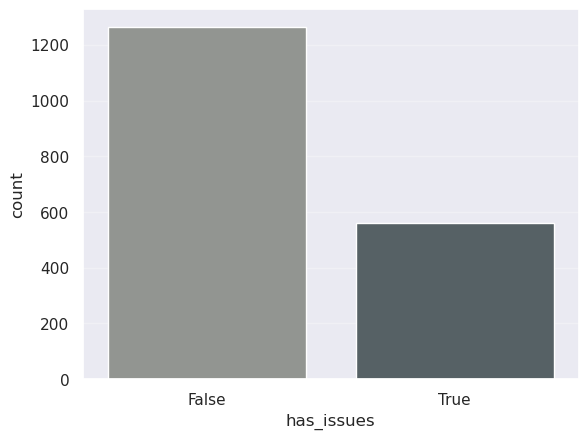

In [71]:
boolcolors = ["#929591", "#536267"] # grey,gunmetal
 
sns.set(palette=boolcolors)
bar = sns.countplot(data=gh_stats, x='has_issues')  
#plt.xticks(rotation=20)
#plt.yticks(rotation=20)
plt.title(f"Repos with 1+ Issue Ticket (open or closed); N={len(gh_stats)}")
plt.xlabel(f"{gh_stats.has_issues.value_counts(normalize=True)[True].round(2)*100}% Use Issue Tickets")

# Define some hatches
hatches = ['/', '|']

# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.show()

#69% No Issues, 31% Issue Tickets

In [76]:
#boolcolors = ["#929591", "#d1b26f"] # xkcd grey, tan https://xkcd.com/color/rgb/  
# boolcolors = ["#c5c9c7", "#a8a495"] # silver=False, greyish=True
 
# sns.set(palette=boolcolors)
# bar = sns.countplot(data=gh_stats, x='has_PRs')  
# plt.xticks(rotation=20)
# plt.yticks(rotation=20)
# plt.title(f"Repos with at least 1 Pull Request; N={len(gh_stats)}")
# plt.xlabel("Uses Pull Requests")

# # Define some hatches
# hatches = ['|', '.']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

# plt.show()

#65% No PRs, 35% PRs 
print(gh_stats.has_PRs.value_counts(normalize=True)[False].round(2)*100)
len(gh_stats)

65.0


1823

In [ ]:
#boolcolors = ["#929591", "#d1b26f"] # xkcd grey, tan https://xkcd.com/color/rgb/  
boolcolors = ["#c5c9c7", "#a8a495"] # silver=False, greyish=True
 
sns.set(palette=boolcolors)
bar = sns.countplot(data=gh_stats, x='has_PRs')  
plt.xticks(rotation=20)
plt.yticks(rotation=20)
plt.title(f"Repos with at least 1 Pull Request; N={len(gh_stats)}")
plt.xlabel("Uses Pull Requests")

# Define some hatches
hatches = ['|', '.']

# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.show()

#65% No PRs, 35% PRs 


In [7]:
PRs_df = pd.DataFrame(gh_stats.has_PRs)
iss_df = pd.DataFrame(gh_stats.has_issues)

stats_df = pd.concat(objs=[PRs_df, iss_df], axis=1)
stats_df

,has_PRs,has_issues
0,False,False
1,True,True
2,True,True
3,True,True
4,False,False
...,...,...
1871,False,False
1872,True,True
1873,True,True
1874,False,False


In [207]:
stats_df

,has_PRs,has_issues
0,False,False
1,True,True
2,True,True
3,True,True
4,False,False
...,...,...
1871,False,False
1872,True,True
1873,True,True
1874,False,False


# Plotting Data Starts HERE

In [25]:
# get stats from gh_stats for big20top10: 

repo_list = [
    'Dallinger/Dallinger',
    'Axelrod-Python/Axelrod',
    'CICE-Consortium/CICE',
    'MPAS-Dev/compass',
    'kinverarity1/lasio',
    'astrorama/SourceXtractorPlusPlus',
    'CICE-Consortium/Icepack',
    'NOAA-GFDL/MDTF-diagnostics',
    'uwescience/pulse2percept',
    'JeschkeLab/DeerLab'
    ]

gh_stats = pd.read_csv('../../data/gh_stats_2024-02-14.csv', header=0)
gh_stats

count404s = len(gh_stats.loc[gh_stats['initial_HTTP_code'] != 200])
gh_stats = gh_stats.loc[gh_stats['initial_HTTP_code'] == 200]

gh_stats['has_issues'] = np.where((gh_stats['open_tickets'] > 1) | (gh_stats['closed_tickets'] > 1), True, False)
gh_stats['all_tickets'] = (gh_stats['open_tickets'] + gh_stats['closed_tickets'])
gh_stats['uses_both'] = np.where((gh_stats['has_issues'] is True) and (gh_stats['has_PRs'] is True), True, False)
len(gh_stats.index)

read_in_location='../../data/'

big20top10 = [
    'devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv', 
    'devs-assignments_CICE-Consortium-CICE_2024-03-11.csv', 
    'devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv', 
    'devs-assignments_Dallinger-Dallinger_2024-03-11.csv',
    'devs-assignments_JeschkeLab-DeerLab_2024-03-11.csv',
    'devs-assignments_MPAS-Dev-compass_2024-03-11.csv',
    'devs-assignments_NOAA-GFDL-MDTF-diagnostics_2024-03-11.csv',
    'devs-assignments_astrorama-SourceXtractorPlusPlus_2024-03-11.csv',
    'devs-assignments_kinverarity1-lasio_2024-03-11.csv',
    'devs-assignments_uwescience-pulse2percept_2024-03-11.csv'
]

collated_df = pd.DataFrame()

for file in big20top10:
    filepath = f"{read_in_location}{file}"
    origin = file
    print(filepath)
    content_df = pd.read_csv(filepath, header=0)
    content_df['origin'] = origin
    #print(content_df)
    collated_df = pd.concat([collated_df, content_df], )
    print(len(collated_df.index))

print(len(collated_df.index))

dev_assignments = collated_df

# remove outlier dev
dev_assignments = dev_assignments.loc[dev_assignments['total'] < 600]

../../data/devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv
74
../../data/devs-assignments_CICE-Consortium-CICE_2024-03-11.csv
96
../../data/devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv
116
../../data/devs-assignments_Dallinger-Dallinger_2024-03-11.csv
146
../../data/devs-assignments_JeschkeLab-DeerLab_2024-03-11.csv
158
../../data/devs-assignments_MPAS-Dev-compass_2024-03-11.csv
188
../../data/devs-assignments_NOAA-GFDL-MDTF-diagnostics_2024-03-11.csv
206
../../data/devs-assignments_astrorama-SourceXtractorPlusPlus_2024-03-11.csv
216
../../data/devs-assignments_kinverarity1-lasio_2024-03-11.csv
236
../../data/devs-assignments_uwescience-pulse2percept_2024-03-11.csv
260
260


In [13]:
dev_assignments.columns

Index(['Unnamed: 0', 'dev_name', 'total', 'PRs', 'issues', 'login', 'type',
       'contributions', 'email', 'name', 'assignment', 'origin'],
      dtype='object')

In [14]:
PRs_df = pd.DataFrame(gh_stats.has_PRs)
iss_df = pd.DataFrame(gh_stats.has_issues)

stats_df = pd.concat(objs=[PRs_df, iss_df], axis=1)
df_long = stats_df.melt(value_vars=['has_PRs', 'has_issues'], value_name='Repositories').replace({'Repositories': {False: 'Not Using', True: 'Using'}})

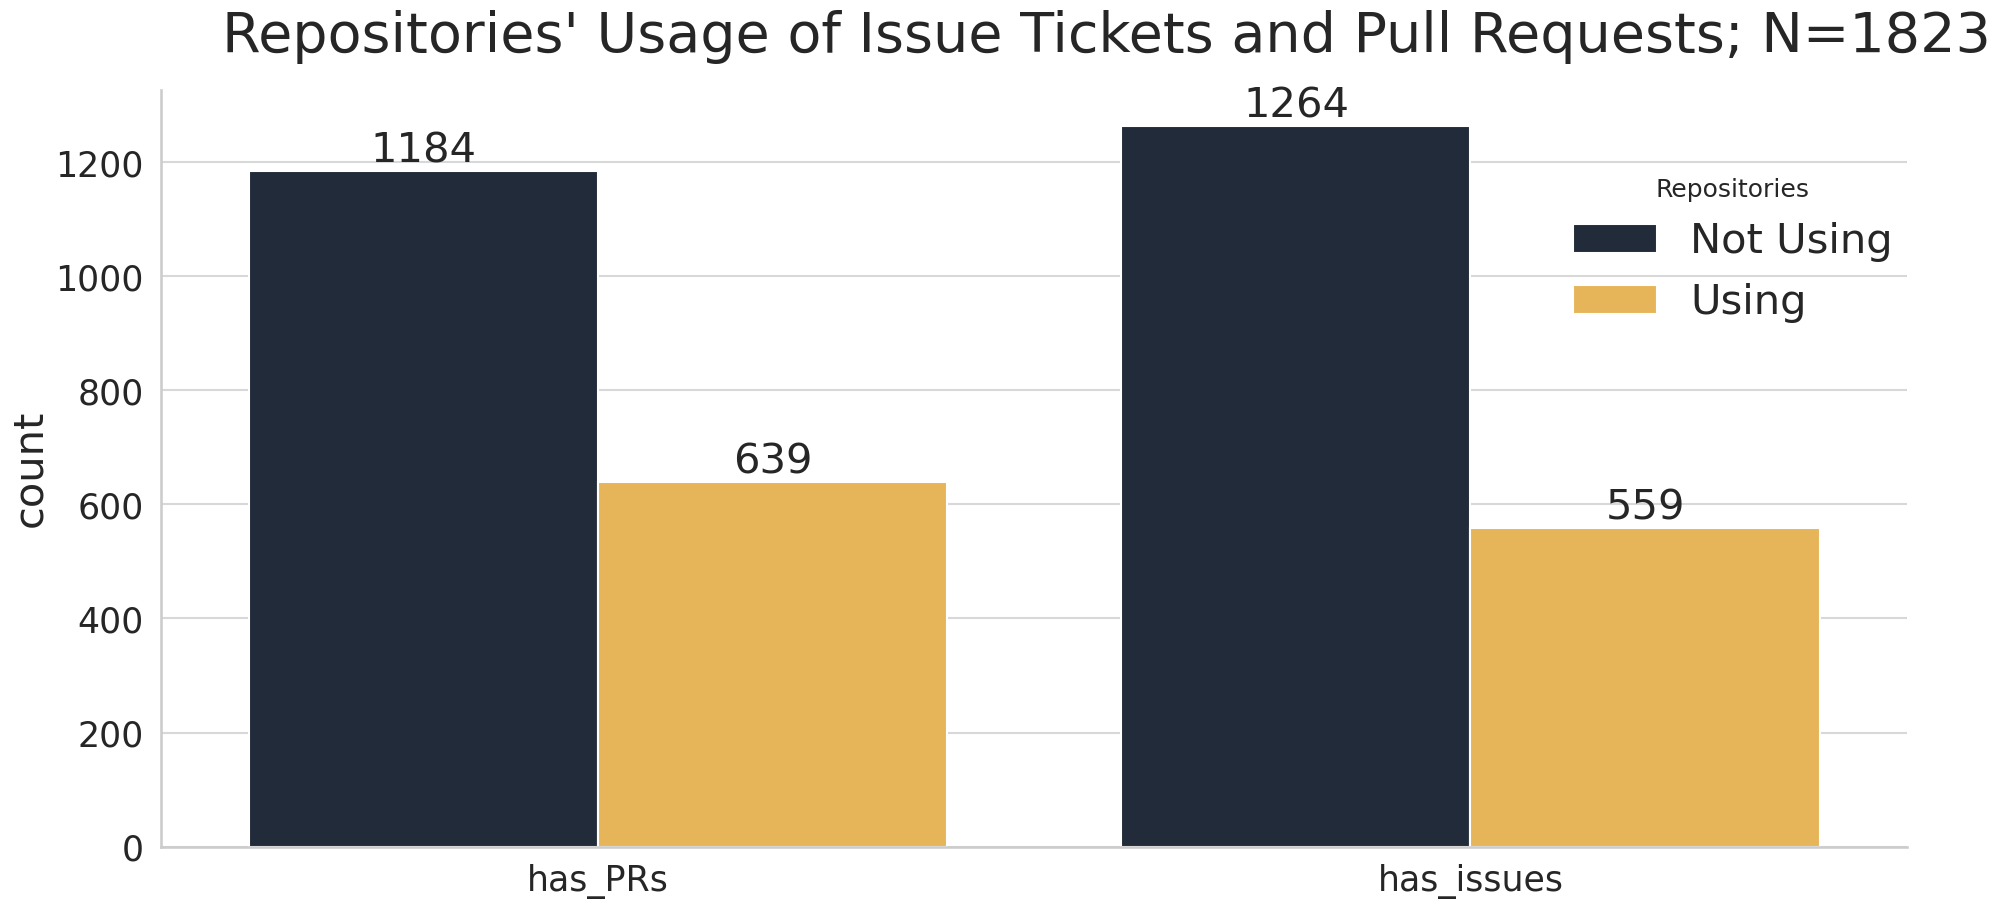

In [15]:
usenotusecolours = ["#1D2A3D", "#FDBC42"] # epccnavy, dandelion
sns.set_theme(context='talk', style='whitegrid', palette=usenotusecolours,  rc={"lines.markersize":12, "legend.fontsize":30, "legend.frameon": True, "font.size":30,"axes.titlesize":40,"axes.labelsize":30, "xtick.labelsize":25, "ytick.labelsize":25, "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
plt = sns.catplot(kind='count', data=df_long,
                x='variable', hue='Repositories', height=10, aspect=2, legend=True)
plt.set(xlabel='')
sns.move_legend(plt, 'upper right', bbox_to_anchor=(0.85, 0.85))
for ax in plt.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars)
plt.figure.subplots_adjust(top=0.90)
plt.figure.suptitle(f"Repositories' Usage of Issue Tickets and Pull Requests; N={len(gh_stats)}", size=40)
plt.savefig("../../images/bars_usage.png", dpi=1000) 
# to obtain: 

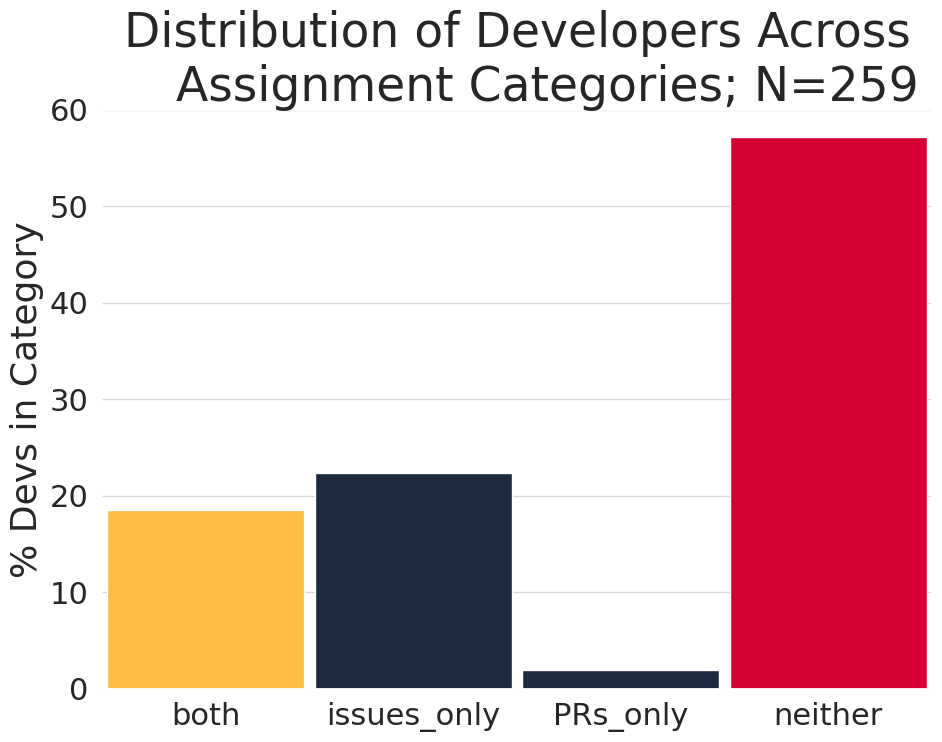

In [18]:
cat_palette = {'both': "#FDBC42", 'issues_only':  "#1D2A3D", 'PRs_only': "#1D2A3D", 'neither': "#D50032"}
palette_list = list(cat_palette.values())
(
    so.Plot(
        data=dev_assignments, 
        x='assignment',
        color='assignment'
    )
    .add(so.Bars(width=.95, alpha=1), so.Hist(stat='percent'), legend=False)
    .scale(x=so.Nominal(order=cat_order), color=so.Nominal(palette_list, order=cat_order), legend=False)
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .theme({"font.size":26,"axes.titlesize":34,"axes.labelsize":26, "xtick.labelsize":22, "ytick.labelsize":22})
    .label(y='% Devs in Category')
    .label(x='')
    .label(title=f"""Distribution of Developers Across
    Assignment Categories; N={len(dev_assignments.index)}""", size=40)
    .layout(size=(10,8)) 
    .save("../../images/bars-distribution-cats.png", dpi=1000)
).show()    




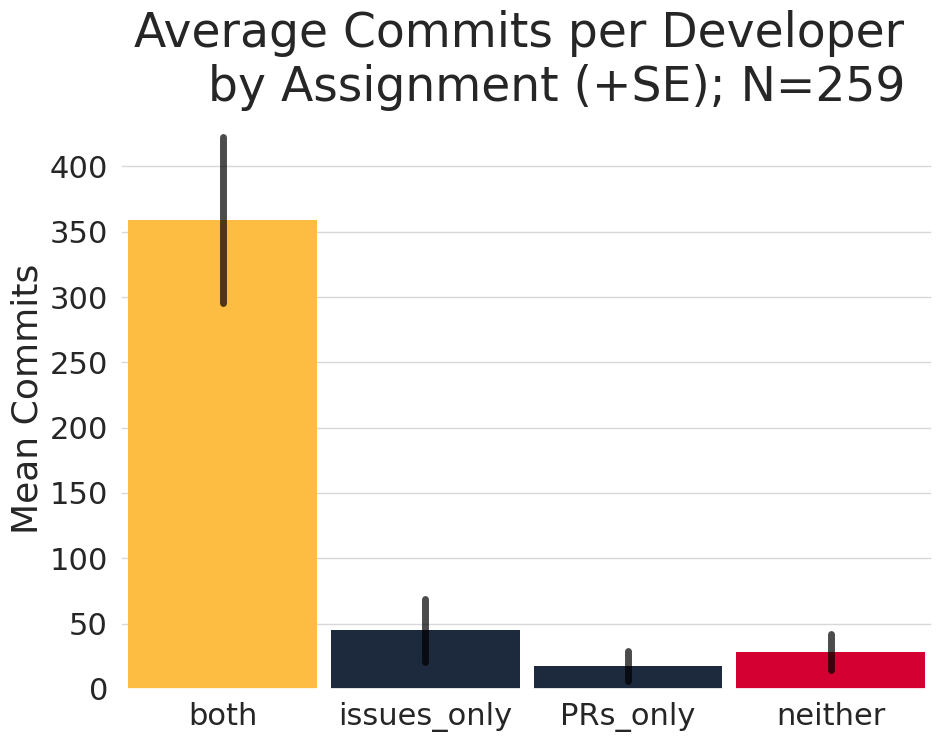

In [23]:
cat_order = ['both','issues_only', 'PRs_only', 'neither']
#cat_palette = {'both': "#2ca02c", 'issues_only':  "#1f77b4", 'PRs_only': "#ff7f0e", 'neither': "#d62728"}
cat_palette = {'both': "#FDBC42", 'issues_only':  "#1D2A3D", 'PRs_only': "#1D2A3D", 'neither': "#D50032"}
palette_list = list(cat_palette.values())

# remove outlier of ~600 total and >2000 contributions
dev_assignments = dev_assignments.loc[dev_assignments['total'] < 600]

(
    so.Plot(data=dev_assignments, x='assignment', y='contributions', color='assignment')
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .theme({"font.size":26,"axes.titlesize":34,"axes.labelsize":26, "xtick.labelsize":22, "ytick.labelsize":22})
    .add(so.Bar(width=.93, alpha=1), so.Agg('mean'), legend=False)
    .scale(x=so.Nominal(order=cat_order), alpha=1, color=so.Nominal(palette_list, order=cat_order), legend=False)
    .add(so.Range(color='black', alpha=0.7, linewidth=5), so.Est(errorbar="se"), legend=None)
    .label(y='Mean Commits')
    .label(x='')
    .label(title=f"""Average Commits per Developer 
    by Assignment (+SE); N={len(dev_assignments.index)}""")
    .layout(size=(10,8)) 
    .save("../../images/bars-mean-commits.png", dpi=1000)
    
).show()


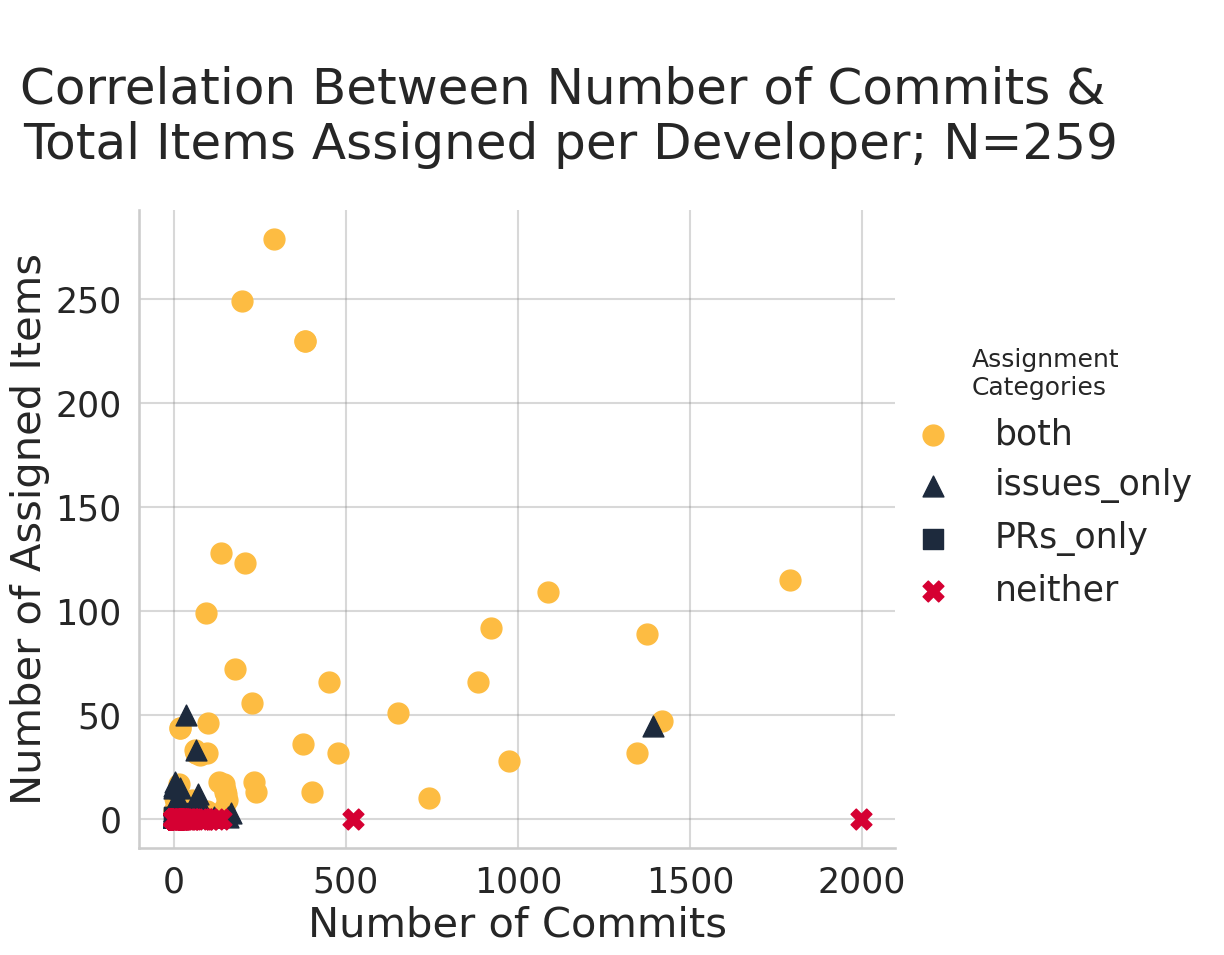

In [24]:
cat_order = ['both','issues_only', 'PRs_only', 'neither']
#cat_palette = {'both': "#2ca02c", 'issues_only':  "#1f77b4", 'PRs_only': "#ff7f0e", 'neither': "#d62728"}
cat_palette = {'both': "#FDBC42", 'issues_only':  "#1D2A3D", 'PRs_only': "#1D2A3D", 'neither': "#D50032"}
palette_list = list(cat_palette.values())


# remove outlier of ~600 total and >2000 contributions
dev_assignments = dev_assignments.loc[dev_assignments['total'] < 600]

sns.set_theme(context='talk', style='whitegrid', rc={"lines.markersize":15, "legend.fontsize":25, "font.size":30,"axes.titlesize":40,"axes.labelsize":30, "xtick.labelsize":25, "ytick.labelsize":25, "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})

plt = sns.lmplot(
    data=dev_assignments, 
    x='contributions', 
    y='total', 
    hue='assignment', 
    hue_order=cat_order,
    palette=cat_palette,
    height=10, 
    markers = ['o', '^', 's', 'X'],
    #lowess=True,
    scatter_kws={'alpha': 1},
    fit_reg = False,
    robust=True,
    legend=False, 
    ci=None
)
plt.fig.subplots_adjust(top=0.78)
plt.fig.suptitle(f"""
Correlation Between Number of Commits & 
Total Items Assigned per Developer; N={len(dev_assignments.index)}"""
)
plt.add_legend(title="""Assignment
Categories""")
plt.set_xlabels('Number of Commits')
plt.set_ylabels('Number of Assigned Items')
plt.savefig("../../images/correlations-lmplot.png", dpi=1000) 
# locally run:  scp eidf:/home/eidf103/eidf103/flic/clonezone/coding-smart/images/correlations-lmplot.png ./images/

In [4]:

repo_list = [
    'Dallinger/Dallinger',
    'Axelrod-Python/Axelrod',
    'CICE-Consortium/CICE',
    'MPAS-Dev/compass',
    'kinverarity1/lasio',
    'astrorama/SourceXtractorPlusPlus',
    'CICE-Consortium/Icepack',
    'NOAA-GFDL/MDTF-diagnostics',
    'uwescience/pulse2percept',
    'JeschkeLab/DeerLab'
]

collated_df = pd.DataFrame()
content_df = pd.DataFrame()

for item in repo_list:
    sanitised_repo_name = item.replace("/", "-")
    origin = f"all-issues_{sanitised_repo_name}_2024-03-19.csv"
    filestr = f"../../data/{origin}"
    content_df = pd.read_csv(filestr, header=0)
    content_df['origin'] = origin
    content_df['repo_name'] = item
    collated_df = pd.concat([collated_df, content_df], )
    #print(len(collated_df.index))

# ADD REQUIRED COLUMNS FOR PLOTTING
collated_df['assigned_bool'] = collated_df['assigned_devs'] != "[]"

collated_df['type'] = np.where((collated_df['is_PR'] ==True ), "PRs", "Issues")
collated_df['assignment'] = np.where((collated_df['assigned_bool'] == True ), "assigned", "unassigned")

#collated_df['type'].value_counts()
#PR       9727
#Issue    2915
#Name: type, dtype: int64

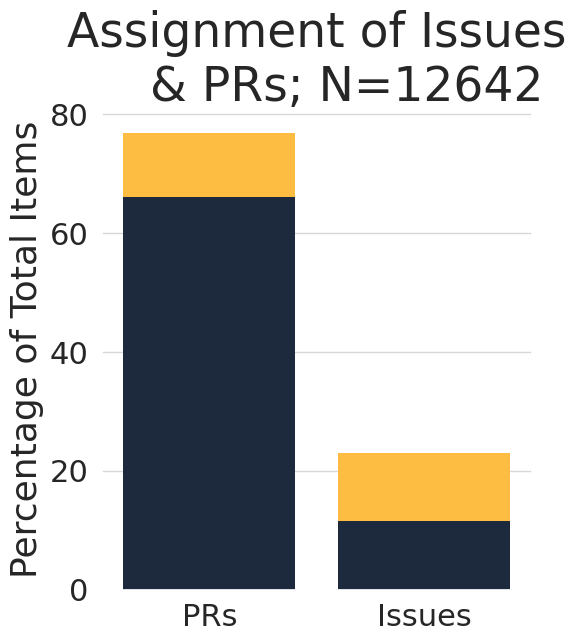

In [11]:
assn_order = ['assigned', 'unassigned']
assn_palette = {'unassigned': "#1D2A3D", 'assigned':"#FDBC42"}

plt = (    
so.Plot(data=collated_df, 
    x='type', 
    color='assignment'
)
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .theme({"font.size":26, "legend.fontsize":22, "axes.titlesize":34,"axes.labelsize":26, "xtick.labelsize":22, "ytick.labelsize":22})
    .add(so.Bar(alpha=1), so.Hist(stat='percent'), so.Stack(), legend=False)
    .scale(color=so.Nominal(assn_palette, order=assn_order), legend=False)
    .label(y='Percentage of Total Items')
    .label(x='')
    .label(title=f"""Assignment of Issues
    & PRs; N={len(collated_df.index)}""")
    .layout(size=(6,7)) 
    .save("../../images/bars-stacked-assignment.png", dpi=1000)
).show()


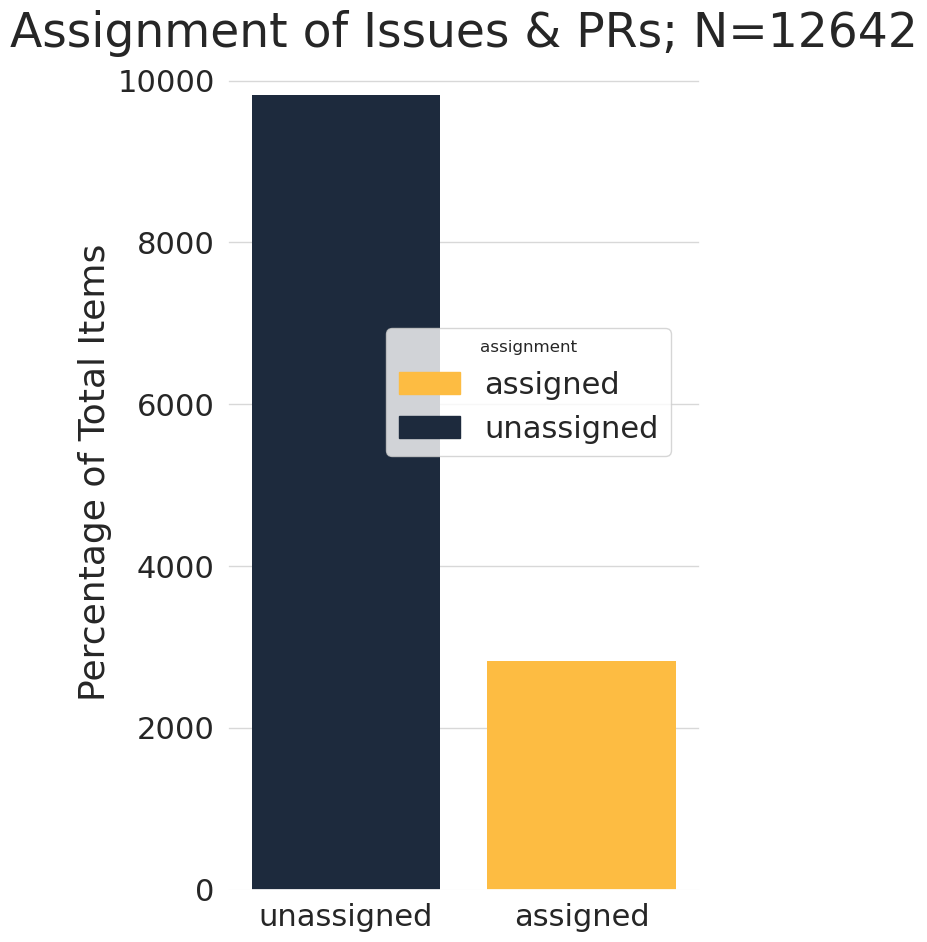

In [10]:
assn_palette = {'unassigned': "#1D2A3D", 'assigned':"#FDBC42"}
plt = (    
so.Plot(
    data=collated_df, 
    x='assignment',
    color='assignment'
)
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .theme({"font.size":26, "legend.fontsize":22, "axes.titlesize":34,"axes.labelsize":26, "xtick.labelsize":22, "ytick.labelsize":22})
    .add(so.Bar(alpha=1), so.Count(), legend=True)
    .scale(color=so.Nominal(assn_palette, order=assn_order), legend=False)
    .label(y='Percentage of Total Items')
    .label(x='')
    .label(title=f"""Assignment of Issues & PRs; N={len(collated_df.index)}""")
    .layout(size=(7,10)) 
    #.save("../../images/bars-stacked-assignment_legend.png", dpi=1000)
).show()

     type  total  assigned  unassigned
0  Issues   2915      1449        1466
1     PRs   9727      1373        8354


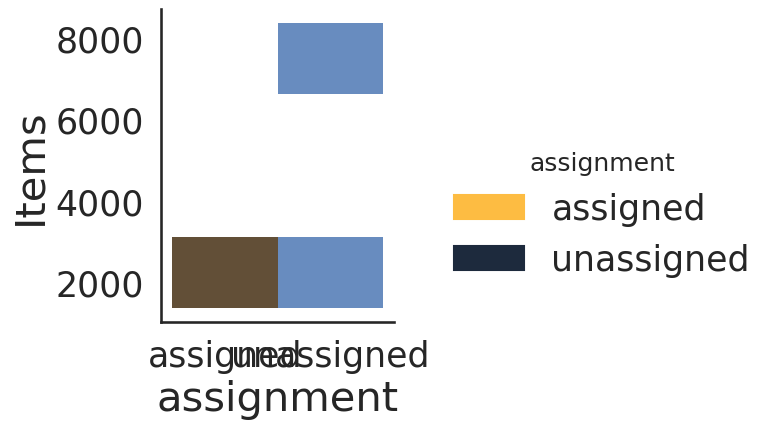

In [63]:

#assn_order = ['assigned', 'unassigned']
#assn_palette = {'unassigned': "#1D2A3D", 'assigned':"#FDBC42", 'both': "#2ca02c", 'issues_only':  "#1f77b4", 'PRs_only': "#ff7f0e", 'neither': "#d62728"}
#assn_list = list(assn_palette.values())
#cols= sns.color_palette(palette=assn_list, n_colors=2)

assn_palette = {'unassigned': "#1D2A3D", 'assigned':"#FDBC42"}
assn_cols = ["#1D2A3D", "#FDBC42"]
sns.set_theme(context='talk', style='white', rc={"lines.markersize":12, "legend.fontsize":25, "font.size":30,"axes.titlesize":40,"axes.labelsize":30, "xtick.labelsize":25, "ytick.labelsize":25, "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})

d = {'type':['Issues', 'PRs'], 'total':[2915, 9727], 'assigned':[1449, 1373], 'unassigned':[1466, 8354]}
big10assignment = pd.DataFrame(data=d)
print(big10assignment)
big10assignment_melt = big10assignment.melt(value_vars=['assigned', 'unassigned'], var_name='assignment' , value_name='Items', id_vars='type')
big10assignment_melt

sns.displot(
    data=big10assignment_melt, 
    x ='assignment',
    y='Items',
    hue='assignment',
    #hue_order=cat_order,
    palette=assn_palette, 
    legend='full'
    #saturation=1
).savefig("../../images/assignment-legend.png", dpi=1000) 

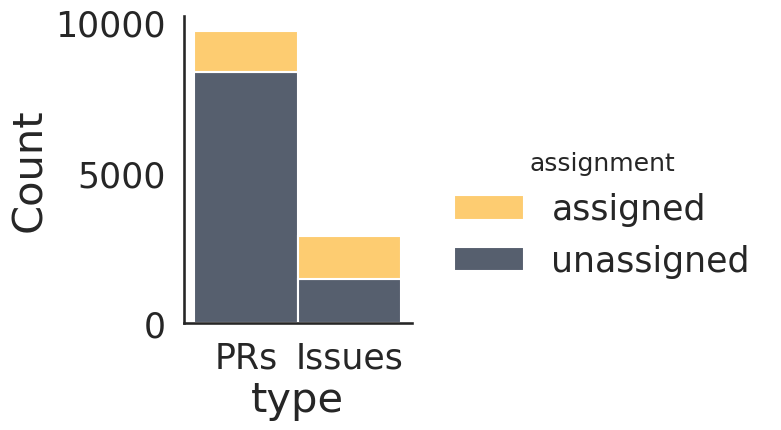

In [62]:
sns.displot(
    data=collated_df, x='type', hue='assignment', 
    multiple='stack', kind='hist', hue_order=['assigned', 'unassigned'], 
    palette=assn_palette
)

In [374]:
collated_df

,Unnamed: 0,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,...,timeline_url,performed_via_github_app,state_reason,assigned_devs,is_PR,origin,repo_name,assigned_bool,type,assignment
0,0,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dallinger,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://github.com/Dallinger/Dallinger/pull/6332,2193416665,PR_kwDOBAU_a85qAasP,6332,...,https://api.github.com/repos/Dallinger/Dalling...,NaN,NaN,[],True,all-issues_Dallinger-Dallinger_2024-03-19.csv,Dallinger/Dallinger,False,PRs,unassigned
1,1,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dallinger,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://github.com/Dallinger/Dallinger/pull/6331,2193416348,PR_kwDOBAU_a85qAanf,6331,...,https://api.github.com/repos/Dallinger/Dalling...,NaN,NaN,[],True,all-issues_Dallinger-Dallinger_2024-03-19.csv,Dallinger/Dallinger,False,PRs,unassigned
2,2,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dallinger,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://github.com/Dallinger/Dallinger/pull/6330,2193415959,PR_kwDOBAU_a85qAaho,6330,...,https://api.github.com/repos/Dallinger/Dalling...,NaN,NaN,[],True,all-issues_Dallinger-Dallinger_2024-03-19.csv,Dallinger/Dallinger,False,PRs,unassigned
3,3,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dallinger,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://github.com/Dallinger/Dallinger/pull/6329,2193107602,PR_kwDOBAU_a85p_UiJ,6329,...,https://api.github.com/repos/Dallinger/Dalling...,NaN,NaN,[],True,all-issues_Dallinger-Dallinger_2024-03-19.csv,Dallinger/Dallinger,False,PRs,unassigned
4,4,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dallinger,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://api.github.com/repos/Dallinger/Dalling...,https://github.com/Dallinger/Dallinger/pull/6328,2190461544,PR_kwDOBAU_a85p2cC1,6328,...,https://api.github.com/repos/Dallinger/Dalling...,NaN,NaN,[],True,all-issues_Dallinger-Dallinger_2024-03-19.csv,Dallinger/Dallinger,False,PRs,unassigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,51,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/5,655081818,MDExOlB1bGxSZXF1ZXN0NDQ3Njc5NTE3,5,...,NaN,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,[],True,all-issues_JeschkeLab-DeerLab_2024-03-19.csv,JeschkeLab/DeerLab,False,PRs,unassigned
452,52,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/4,654982730,MDExOlB1bGxSZXF1ZXN0NDQ3NjAxNDAz,4,...,Wrote fftconvolve KDE to remove KDEpy dependen...,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,[],True,all-issues_JeschkeLab-DeerLab_2024-03-19.csv,JeschkeLab/DeerLab,False,PRs,unassigned
453,53,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repo

In [373]:
assn_order = ['assigned', 'unassigned']
assn_palette = {'unassigned': "#1D2A3D", 'assigned':"#FDBC42"}
palette_list = list(assn_palette.values())

p = (    
so.Plot(
    data=collated_df, 
    x='type', 
    color='assignment' 
)
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .theme({"font.size":26, "legend.fontsize":22, "axes.titlesize":34,"axes.labelsize":26, "xtick.labelsize":22, "ytick.labelsize":22})
    .add(so.Bar(alpha=1), so.Hist(stat='percent'), so.Stack(), legend=False)
    .scale(color=so.Nominal(assn_palette, order=assn_order), legend=False)
    .label(y='Percentage of Total Items')
    .label(x='')
    .label(title=f"""Assignment of Issues & PRs; N={len(collated_df.index)}""")
    .layout(size=(7,10)) 
    #.save("../../images/bars-stacked-assignment_legend.png", dpi=1000)
)

f, ax = plt.subplots()
p.on(ax).show()

AttributeError: 'Plot' object has no attribute 'subplots'

In [77]:
gh_stats

,repo_name,initial_HTTP_code,issues_enabled,repo_is_fork,devs,total_commits_last_year,has_PRs,last_PR_update,open_tickets,closed_tickets,repo_age_days,repo_license,repo_visibility,repo_language,has_issues,all_tickets,uses_both
0,leonmhartman/Gnotobiotic_E.diaphana,200,True,False,1.0,0.0,False,NaN,0.0,0.0,975.0,NaN,True,"dict_keys(['R', 'Shell'])",False,0.0,False
1,ProyectoAether/Aether-Portal,200,True,False,5.0,33.0,True,2023-11-30 11:57:40+00:00,0.0,34.0,336.0,MIT,True,"dict_keys(['Svelte', 'Python', 'TypeScript', '...",True,34.0,False
2,MotionbyLearning/stm,200,True,False,6.0,109.0,True,2024-01-15 17:37:06+00:00,15.0,46.0,478.0,Apache-2.0,True,"dict_keys(['Jupyter Notebook', 'Python'])",True,61.0,False
3,nicolasfara/reconfiguration-experiments,200,True,False,3.0,216.0,True,2024-02-12 13:21:54+00:00,0.0,109.0,148.0,Apache-2.0,True,"dict_keys(['Jupyter Notebook', 'Scala', 'Kotli...",True,109.0,False
4,ashleefv/CFDparticleLungMucosa,200,True,False,1.0,12.0,False,NaN,0.0,0.0,284.0,BSD-3-Clause,True,None,False,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,cwarriner/warriner_etal_2022,200,True,False,1.0,0.0,False,NaN,0.0,0.0,575.0,NaN,True,dict_keys(['MATLAB']),False,0.0,False
1872,CuckooWang/iFPS,200,True,False,1.0,0.0,True,2020-10-02 01:27:25+00:00,0.0,2.0,1303.0,Apache-2.0,True,"dict_keys(['Java', 'Python'])",True,2.0,False
1873,JacquesCarette/Drasil,200,True,False,46.0,842.0,True,2024-02-07 17:15:23+00:00,376.0,3259.0,3447.0,BSD-2-Clause,True,"dict_keys(['Haskell', 'Makefile', 'Shell', 'Py...",True,3635.0,False
1874,OSU-BMBL/Spinal-cord-scRNAseq,200,True,False,1.0,0.0,False,NaN,0.0,0.0,735.0,NaN,True,"dict_keys(['HTML', 'R'])",False,0.0,False


In [78]:
dev_assignments

,Unnamed: 0,dev_name,total,PRs,issues,login,type,contributions,email,name,assignment,origin
0,0,Chadys,1.0,0.0,1.0,Chadys,User,53.0,NaN,NaN,issues_only,devs-assignments_Axelrod-Python-Axelrod_2024-0...
1,1,Nikoleta-v3,4.0,1.0,3.0,Nikoleta-v3,User,97.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
2,2,drvinceknight,115.0,8.0,107.0,drvinceknight,User,1791.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
3,3,gaffney2010,1.0,0.0,1.0,gaffney2010,User,158.0,NaN,NaN,issues_only,devs-assignments_Axelrod-Python-Axelrod_2024-0...
4,4,marcharper,28.0,4.0,24.0,marcharper,User,974.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
...,...,...,...,...,...,...,...,...,...,...,...,...
19,28,apurvvarshney,0.0,0.0,0.0,apurvvarshney,User,2.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...
20,29,garethgeorge,0.0,0.0,0.0,garethgeorge,User,1.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...
21,30,ascientist,0.0,0.0,0.0,ascientist,User,1.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...
22,31,oliver-contier,0.0,0.0,0.0,oliver-contier,User,1.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...


In [81]:
iss_filename = f"{read_in_location}all-issues_Dallinger-Dallinger_2024-03-19.csv"
iss_df = pd.read_csv(iss_filename, header=0)

In [83]:
iss_df.columns

Index(['Unnamed: 0', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'draft', 'pull_request',
       'body', 'reactions', 'timeline_url', 'performed_via_github_app',
       'state_reason', 'assigned_devs', 'is_PR'],
      dtype='object')

In [98]:
iss_df['assigned_bool'] = iss_df.assigned_devs != "[]"

In [104]:
len(iss_df.index)

6332

In [102]:
iss_df['assigned_bool'].value_counts(normalize=True)

False    5916
True      416
Name: assigned_bool, dtype: int64

In [108]:
iss_df['is_PR'].value_counts(normalize=True)

True     0.877606
False    0.122394
Name: is_PR, dtype: float64

In [107]:
iss_df.groupby(by='is_PR')['assigned_bool'].value_counts(normalize=True)

is_PR  assigned_bool
False  False            0.646452
       True             0.353548
True   False            0.974447
       True             0.025553
Name: assigned_bool, dtype: float64

In [ ]:
# for 1 repo: 6332 items

# 88% are PRs, 12% are Issues  

# of PRs: only 35% are assigned. 
# of Issues: only 3% are assigned.


#PRs_df = pd.DataFrame(gh_stats.has_PRs)
#iss_df = pd.DataFrame(gh_stats.has_issues)

#stats_df = pd.concat(objs=[PRs_df, iss_df], axis=1)
#df_long = stats_df.melt(value_vars=['has_PRs', 'has_issues'], value_name='Repositories').replace({'Repositories': {False: 'Not Using', True: 'Using'}})


In [127]:
repo_list = [
    'Dallinger/Dallinger',
    'Axelrod-Python/Axelrod',
    'CICE-Consortium/CICE',
    'MPAS-Dev/compass',
    'kinverarity1/lasio',
    'astrorama/SourceXtractorPlusPlus',
    'CICE-Consortium/Icepack',
    'NOAA-GFDL/MDTF-diagnostics',
    'uwescience/pulse2percept',
    'JeschkeLab/DeerLab'
]

collated_df = pd.DataFrame()
content_df = pd.DataFrame()

for item in repo_list:
    sanitised_repo_name = item.replace("/", "-")
    origin = f"all-issues_{sanitised_repo_name}_2024-03-19.csv"
    filestr = f"../../data/{origin}"
    content_df = pd.read_csv(filestr, header=0)
    content_df['origin'] = origin
    content_df['repo_name'] = item
    collated_df = pd.concat([collated_df, content_df], )
    #print(len(collated_df.index))

#collated_df.columns
collated_df['assigned_bool'] = collated_df['assigned_devs'] != "[]"

6332
7771
8710
9506
10078
10644
11128
11575
12186
12642


Index(['Unnamed: 0', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'draft', 'pull_request',
       'body', 'reactions', 'timeline_url', 'performed_via_github_app',
       'state_reason', 'assigned_devs', 'is_PR', 'origin', 'repo_name'],
      dtype='object')

In [128]:
collated_df['assigned_bool'] = collated_df['assigned_devs'] != "[]"

In [137]:
round(collated_df.groupby(by='repo_name')['assigned_bool'].value_counts(normalize=True), 2)*100  
# percentages assigned per repo

repo_name                         assigned_bool
Axelrod-Python/Axelrod            False            87.0
                                  True             13.0
CICE-Consortium/CICE              True             50.0
                                  False            50.0
CICE-Consortium/Icepack           False            53.0
                                  True             47.0
Dallinger/Dallinger               False            93.0
                                  True              7.0
JeschkeLab/DeerLab                False            67.0
                                  True             33.0
MPAS-Dev/compass                  True             90.0
                                  False            10.0
NOAA-GFDL/MDTF-diagnostics        True             69.0
                                  False            31.0
astrorama/SourceXtractorPlusPlus  False            81.0
                                  True             19.0
kinverarity1/lasio                False            82.0


In [185]:
round(collated_df.groupby(by=['repo_name', 'is_PR'])['assigned_bool'].value_counts(), 2)

repo_name                         is_PR  assigned_bool
Axelrod-Python/Axelrod            False  False             283
                                         True              179
                                  True   False             964
                                         True               13
CICE-Consortium/CICE              False  True              322
                                         False              71
                                  True   False             394
                                         True              152
CICE-Consortium/Icepack           False  True               98
                                         False              41
                                  True   False             215
                                         True              130
Dallinger/Dallinger               False  False             501
                                         True              274
                                  True   False            5415


In [183]:
round(collated_df.groupby(by=['repo_name', 'is_PR'])['assigned_bool'].value_counts(normalize=True), 2)
# These are issue & PR assignment percentages PER REPO

repo_name                         is_PR  assigned_bool
Axelrod-Python/Axelrod            False  False            0.61
                                         True             0.39
                                  True   False            0.99
                                         True             0.01
CICE-Consortium/CICE              False  True             0.82
                                         False            0.18
                                  True   False            0.72
                                         True             0.28
CICE-Consortium/Icepack           False  True             0.71
                                         False            0.29
                                  True   False            0.62
                                         True             0.38
Dallinger/Dallinger               False  False            0.65
                                         True             0.35
                                  True   False            0.97


In [210]:
# get all records which is_PR = True, then get N assigned of those of total number of PRs, and calc percentage. 
len(collated_df[collated_df['is_PR'] == True].index) # Number of PRs = 9727
PRs_big10 = collated_df[collated_df['is_PR'] == True]

#PRs_count = PRs_big10.groupby(by='repo_name').size() # count PRs in repo.
# repo_name
# Axelrod-Python/Axelrod               977
# CICE-Consortium/CICE                 546
# CICE-Consortium/Icepack              345
# Dallinger/Dallinger                 5557
# JeschkeLab/DeerLab                   276
# MPAS-Dev/compass                     659
# NOAA-GFDL/MDTF-diagnostics           295
# astrorama/SourceXtractorPlusPlus     393
# kinverarity1/lasio                   300
# uwescience/pulse2percept             379
# dtype: int64

#tmp = PRs_big10.groupby(by='repo_name').assigned_bool.agg(PRs_assigned='sum')
# 	PRs_assigned
# repo_name	
# Axelrod-Python/Axelrod	13
# CICE-Consortium/CICE	152
# CICE-Consortium/Icepack	130
# Dallinger/Dallinger	142
# JeschkeLab/DeerLab	93
# MPAS-Dev/compass	608
# NOAA-GFDL/MDTF-diagnostics	194
# astrorama/SourceXtractorPlusPlus	20
# kinverarity1/lasio	11
# uwescience/pulse2percept	10


PRs_count = PRs_big10.groupby(by='repo_name').is_PR.agg('sum') # count PRs per repo
PRs_assigned = PRs_big10.groupby(by='repo_name').assigned_bool.agg(PRs_assigned='sum')

PRs_df = pd.merge(left=PRs_count, right=PRs_assigned, on='repo_name')
PRs_df
##type(PRs_count)

,is_PR,PRs_assigned
repo_name,,
Axelrod-Python/Axelrod,977,13
CICE-Consortium/CICE,546,152
CICE-Consortium/Icepack,345,130
Dallinger/Dallinger,5557,142
JeschkeLab/DeerLab,276,93
MPAS-Dev/compass,659,608
NOAA-GFDL/MDTF-diagnostics,295,194
astrorama/SourceXtractorPlusPlus,393,20
kinverarity1/lasio,300,11


In [218]:
sum(PRs_df.is_PR) # 9727, all good
sum(PRs_df.PRs_assigned) # 1373, sounds legit.

print(f"{(sum(PRs_df.PRs_assigned) / sum(PRs_df.is_PR))*100}% of PRs are ASSIGNED for big10 repos")

14.115349028477434% of PRs are ASSIGNED


In [235]:
len(collated_df[collated_df['is_PR'] == False].index) # Number of Issues = 2915
issues_big10 = collated_df[collated_df['is_PR'] == False]

issues_big10.groupby(by='repo_name').size() # count issues per repo
# repo_name
# Axelrod-Python/Axelrod              462
# CICE-Consortium/CICE                393
# CICE-Consortium/Icepack             139
# Dallinger/Dallinger                 775
# JeschkeLab/DeerLab                  180
# MPAS-Dev/compass                    137
# NOAA-GFDL/MDTF-diagnostics          152
# astrorama/SourceXtractorPlusPlus    173
# kinverarity1/lasio                  272
# uwescience/pulse2percept            232
# dtype: int64

issues_big10.groupby(by='repo_name').assigned_bool.agg(issues_assigned='sum')
# 	issues_assigned
# repo_name	
# Axelrod-Python/Axelrod	179
# CICE-Consortium/CICE	322
# CICE-Consortium/Icepack	98
# Dallinger/Dallinger	274
# JeschkeLab/DeerLab	59
# MPAS-Dev/compass	105
# NOAA-GFDL/MDTF-diagnostics	114
# astrorama/SourceXtractorPlusPlus	87
# kinverarity1/lasio	94
# uwescience/pulse2percept	117



issues_count = issues_big10.groupby(by='repo_name').is_PR.agg(is_issue='count') # count PRs per repo
issues_assigned = issues_big10.groupby(by='repo_name').assigned_bool.agg(issues_assigned='sum')

issues_df = pd.merge(left=issues_count, right=issues_assigned, on='repo_name')
issues_df

#sum(issues_df.is_issue) # 2915, all good (9727+2915=12642 as above)
#sum(issues_df.issues_assigned) # 1449, sounds legit.

print(f"{(sum(issues_df.issues_assigned) / sum(issues_df.is_issue))*100}% of Issues are ASSIGNED for big10 repos")

49.708404802744425% of Issues are ASSIGNED


In [239]:
d = {'type':['Issues', 'PRs'], 'total':[2915, 9727], 'assigned':[1449, 1373], 'unassigned':[1466, 8354]}
big10assignment = pd.DataFrame(data=d)
print(big10assignment)
big10assignment_melt = big10assignment.melt(value_vars=['assigned', 'unassigned'], var_name='assignment' , value_name='Items', id_vars='type')
big10assignment_melt

     type  total  assigned  unassigned
0  Issues   2915      1449        1466
1     PRs   9727      1373        8354


In [244]:
#stats_df.melt(value_vars=['has_PRs', 'has_issues'], value_name='Repositories').replace({'Repositories': {False: 'Not Using', True: 'Using'}})
big10assignment_melt = big10assignment.melt(value_vars=['assigned', 'unassigned'], var_name='assignment' , value_name='Items', id_vars='type')
big10assignment_melt

,type,assignment,Items
0,Issues,assigned,1449
1,PRs,assigned,1373
2,Issues,unassigned,1466
3,PRs,unassigned,8354


In [255]:
collated_df.columns

Index(['Unnamed: 0', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'draft', 'pull_request',
       'body', 'reactions', 'timeline_url', 'performed_via_github_app',
       'state_reason', 'assigned_devs', 'is_PR', 'origin', 'repo_name',
       'assigned_bool', 'type', 'assignment'],
      dtype='object')

# END OF POSTER USAGE 

In [ ]:
###### NEXT STEPS: 

# Calculate how many issues in total for repo, and how many are assigned to anybody.  
# This might be len(issues_df) - (len(is.null(whichever code is issues_df.column-with-devnames-if-assigned))
# this would give total N tickets - N unassigned tickets for that repo BUT this would include PRs.
# so I'd want to do a version which is more specific. 

# THEN redo use/non-use plot with stacked bars and colour the stacked bits by blue for issues and orange for PRs as usual. 


In [18]:
'pull_request' in iss_df.columns

True

In [7]:
if iss_df['state'].nunique() > 1:
    print(f"There are {iss_df.state.value_counts().open} open issues (~{round(iss_df.state.value_counts(normalize=True).open*100)}%) and {iss_df.state.value_counts().closed} closed issues (~{round(iss_df.state.value_counts(normalize=True).closed*100)}%).")
else: 
    if iss_df['state'][0] == 'closed': # if we have only closed, set open to 0
        print(f"There are 0 open issues (0%) and {iss_df.state.value_counts().closed} closed issues (~{round(iss_df.state.value_counts(normalize=True).closed*100)}%).")
    elif iss_df['state'][0] == 'open': # do vice versa!    
        print(f"There are {iss_df.state.value_counts().open} open issues (~{round(iss_df.state.value_counts(normalize=True).open*100)}%) and 0 closed issues (0).")
    else:
        print("Error in the 'state' column of issues df.")

There are 0 open issues (0%) and 34 closed issues (~100%).


In [8]:
repo_list_full_sample[0:10]

1                ProyectoAether/Aether-Portal
2                        MotionbyLearning/stm
3     nicolasfara/reconfiguration-experiments
9                           bihealth/altamisa
10             FIoT-Client/fiot-client-python
11                      histfitter/histfitter
27                         xiangfstats/GenieR
29                            foxBMS/foxbms-1
38                         tboudreaux/fidanka
40                  AtmosFOAM/AtmosFOAM-tools
Name: repo_name, dtype: object

In [6]:
#print(f"There are {iss_df['is_PR'].value_counts()[False]} issue tickets (~{round(iss_df['is_PR'].value_counts(normalize=True)[False]*100)}%) and {iss_df['is_PR'].value_counts()[True]} pull requests (~{round(iss_df['is_PR'].value_counts(normalize=True)[True]*100)}%).")

KeyError: 'is_PR'

In [14]:
iss_df.columns

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'reactions', 'timeline_url',
       'performed_via_github_app', 'state_reason', 'draft', 'pull_request'],
      dtype='object')

In [6]:
#iss_df['is_PR'] = False
#iss_df['is_PR']

#iss_df
#iss_df['pull_request'].notna() 

if sum(iss_df['is_PR']) >0:
    print(f"There are {iss_df['is_PR'].value_counts()[False]} issue tickets (~{round(iss_df['is_PR'].value_counts(normalize=True)[False]*100)}%) and {iss_df['is_PR'].value_counts()[True]} pull requests (~{round(iss_df['is_PR'].value_counts(normalize=True)[True]*100)}%).")
else:
    print(f"There are {iss_df['is_PR'].value_counts()[False]} issue tickets and (~{round(iss_df['is_PR'].value_counts(normalize=True)[False]*100)}%) no issues that are PRs.")

There are 4 issue tickets (~80%) and 1 pull requests (~20%).


In [19]:
iss_df.dtypes

url                         object
repository_url              object
labels_url                  object
comments_url                object
events_url                  object
html_url                    object
id                           int64
node_id                     object
number                       int64
title                       object
user                        object
labels                      object
state                       object
locked                        bool
assignee                    object
assignees                   object
milestone                   object
comments                     int64
created_at                  object
updated_at                  object
closed_at                   object
author_association          object
active_lock_reason          object
body                        object
reactions                   object
timeline_url                object
performed_via_github_app    object
state_reason                object
draft               

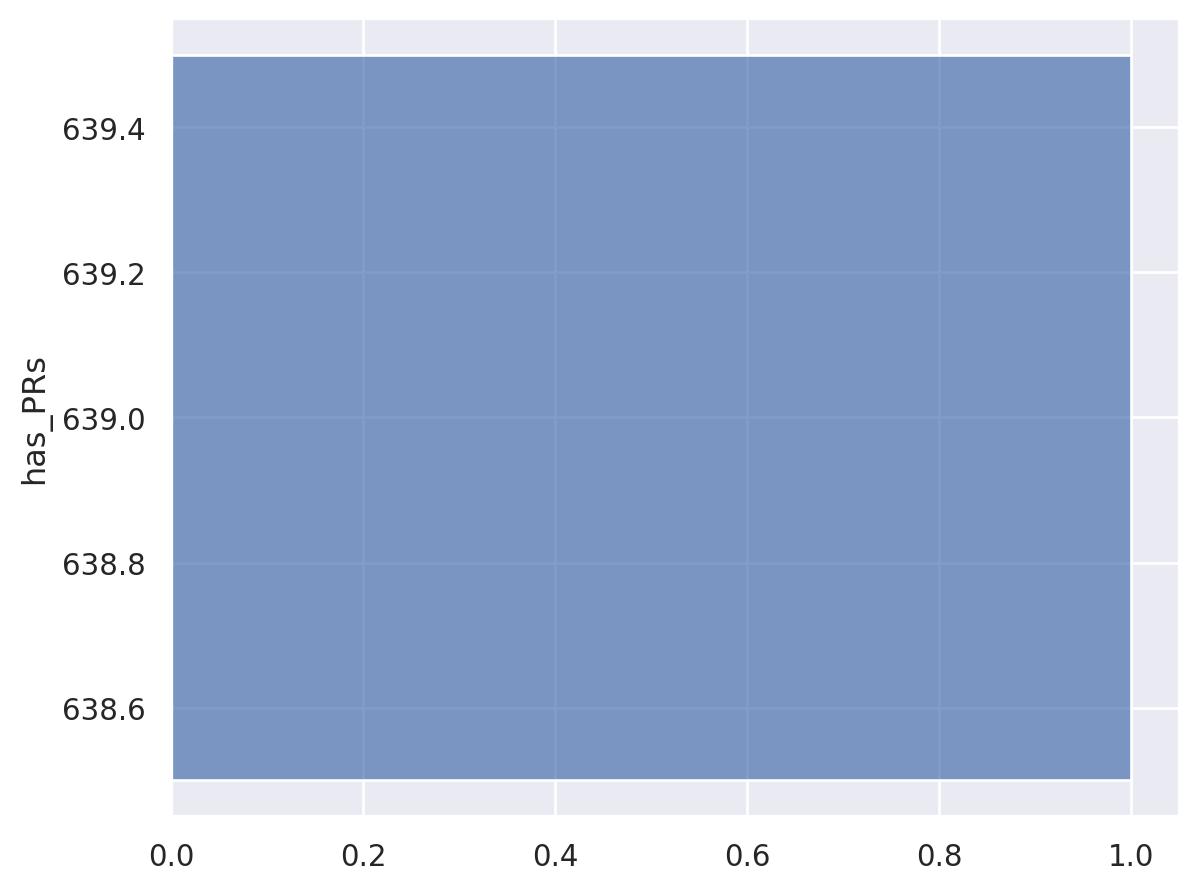

In [188]:
# plotting proportion of RS repos using and assigning Issue Tickets & PRs  
# w/in whole population of repos   

# Barchart 
(
so.Plot(data=stats_df, 
        x=''
        y=
       ).add(so.Bars(), so.Hist())
)

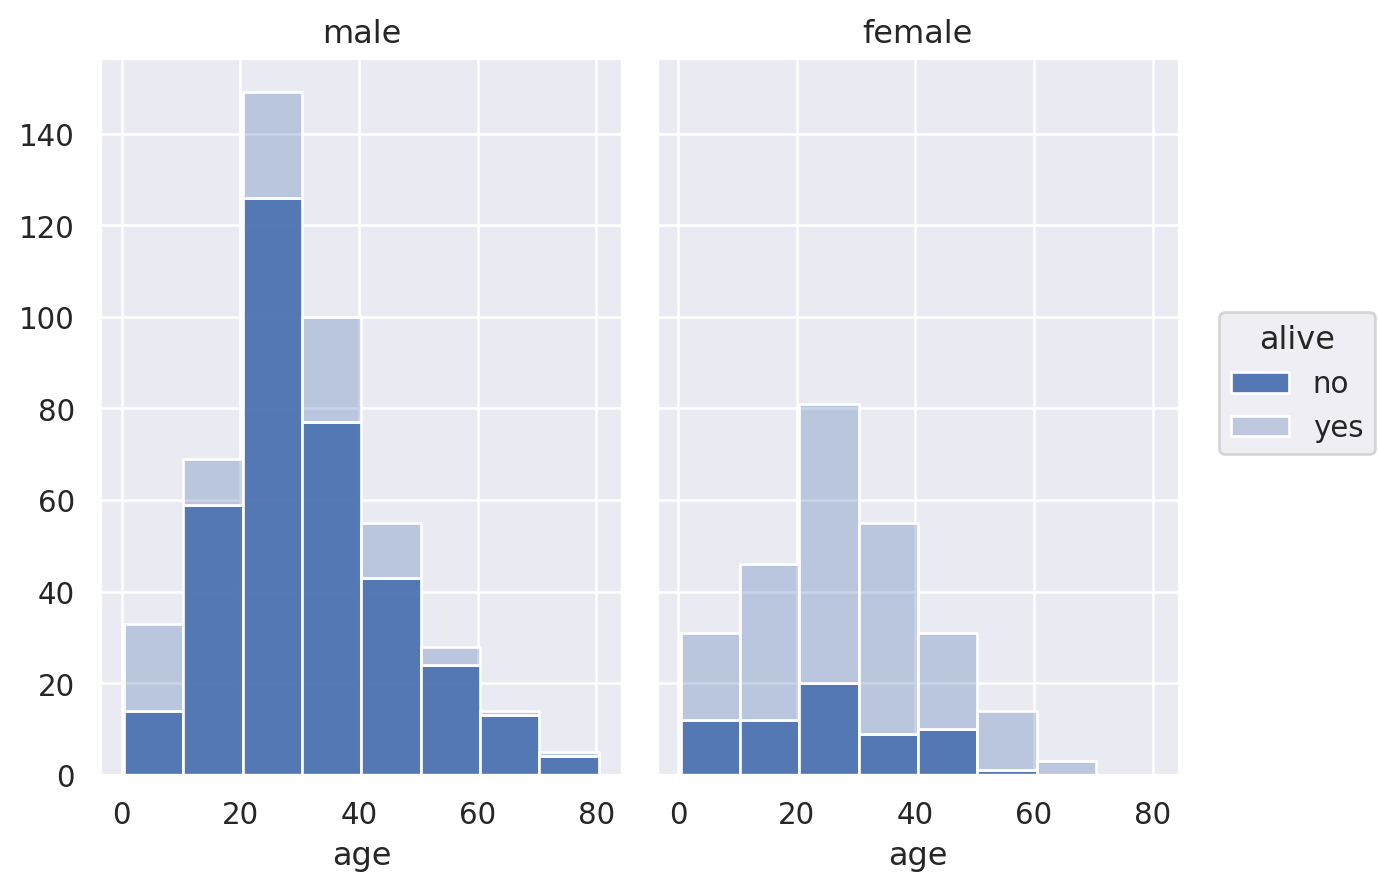

In [179]:
titanic = sns.load_dataset("titanic")
(
    so.Plot(titanic, x="age", alpha="alive")
    .facet("sex")
    .add(so.Bars(), so.Hist(binwidth=10), so.Stack())
)

In [7]:
dev_assignments.columns

Index(['Unnamed: 0', 'dev_name', 'total', 'PRs', 'issues', 'login', 'type',
       'contributions', 'email', 'name', 'assignment', 'repo_name'],
      dtype='object')

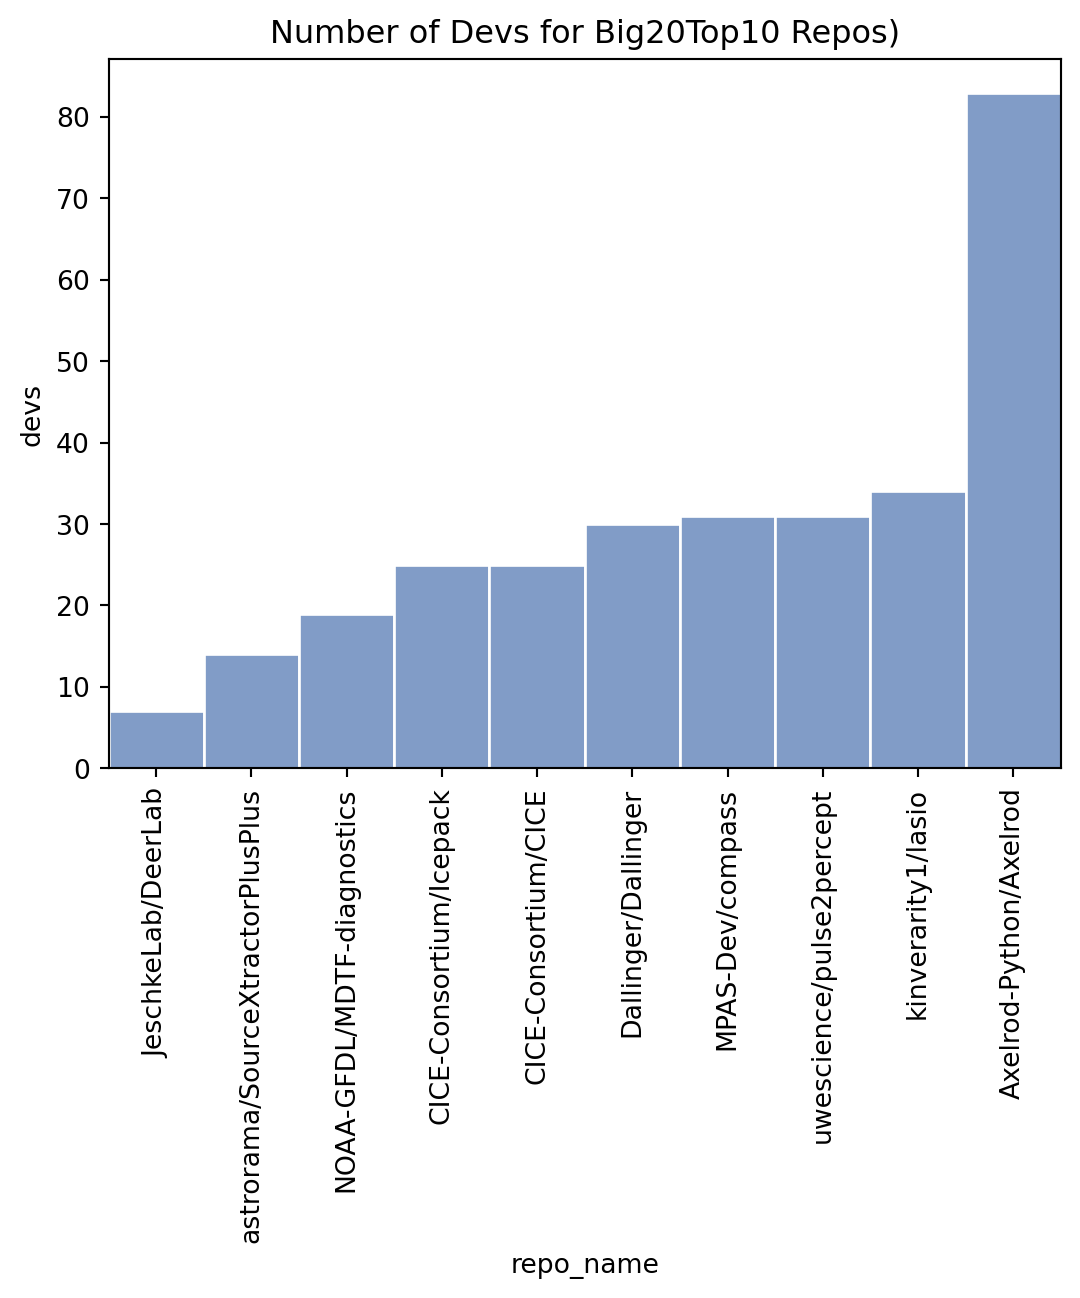

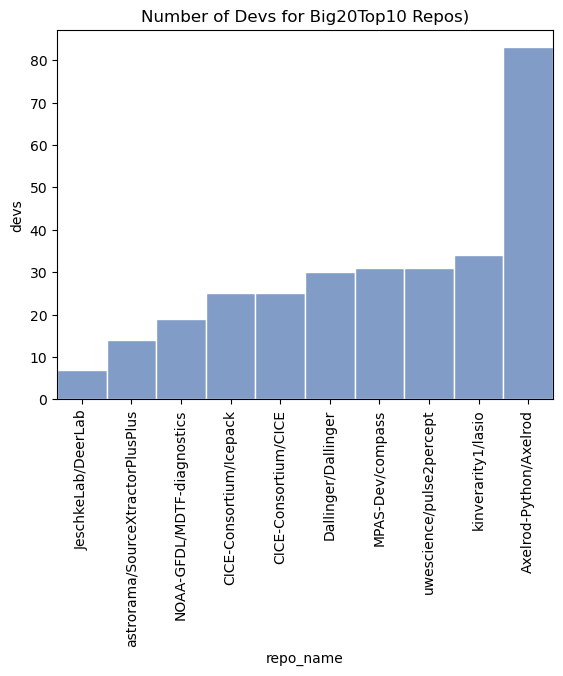

In [243]:
fig, ax = plt.subplots()
ax.xaxis.set_tick_params(rotation=90)  # rotated xlabels via: https://stackoverflow.com/a/75039104

ordered = big20top10stats.sort_values(['devs']).reset_index()

(so.Plot(
    data=ordered,
    x='repo_name', 
    y='devs' 
).add(so.Bars())
 .label(title="Number of Devs for Big20Top10 Repos)")
 .on(ax)
)


In [231]:
lotsdevs = big20top10stats[big20top10stats['devs'] > 80]
print(f"{lotsdevs.iloc[0]['repo_name']} is the repo with more than 80 devs")

Axelrod-Python/Axelrod is the repo with more than 80 devs


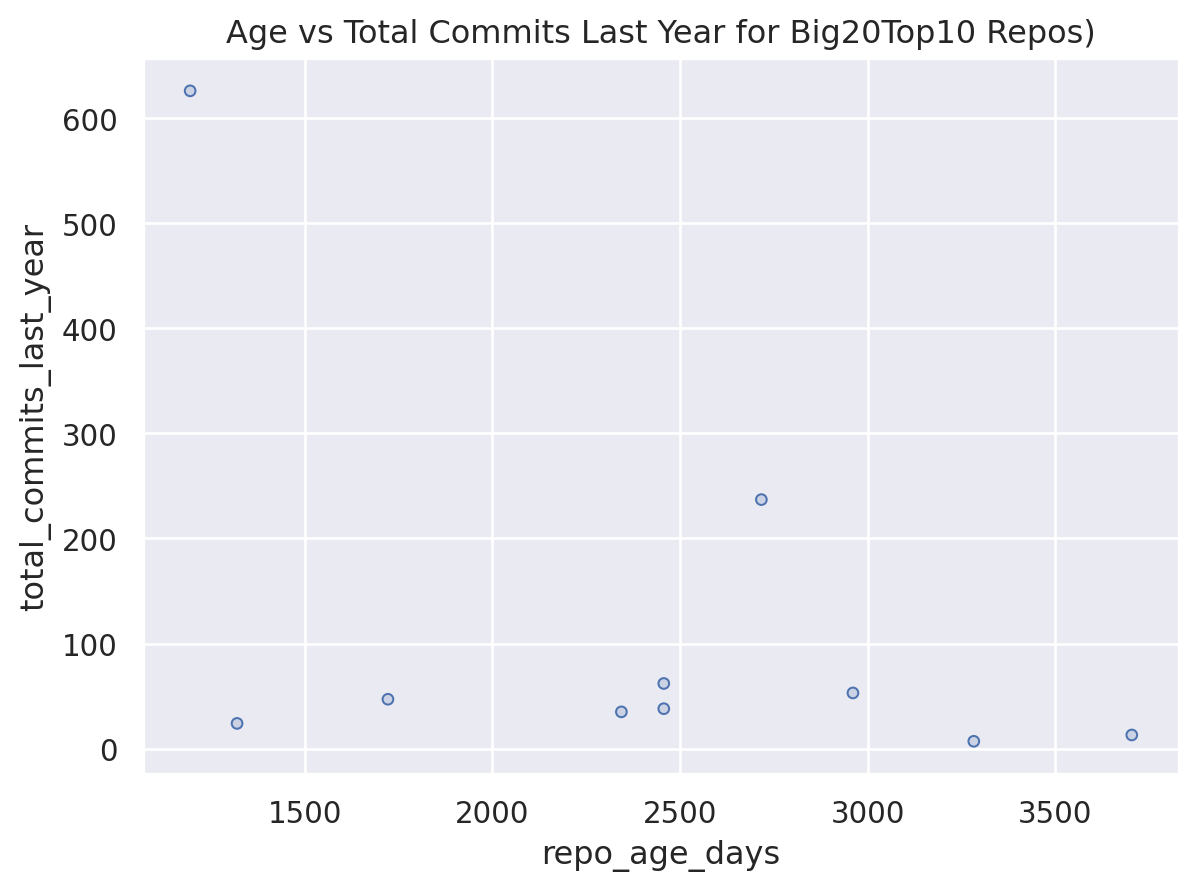

In [189]:

(so.Plot(
    data=big20top10stats,
    x='repo_age_days',
    y='total_commits_last_year'
).add(so.Dots())
 .label(title="Age vs Total Commits Last Year for Big20Top10 Repos)")
)


In [219]:
lotscommits = big20top10stats[big20top10stats['total_commits_last_year'] > 600]
print(f"{lotscommits.iloc[0]['repo_name']} is the repo with more than 600 commits last year")

other_larger = big20top10stats[big20top10stats['total_commits_last_year'] > 200]
other_larger = other_larger[other_larger['total_commits_last_year'] < 300]

print(f"{other_larger.iloc[0]['repo_name']} is the repo with between 200-300 commits last year")

MPAS-Dev/compass is the repo with more than 600 commits last year
Dallinger/Dallinger is the repo with between 200-300 commits last year


## Run get_all_pages_issues( ) and get_repo_contributors( ) for all big20top10

In [10]:
for item in repo_list:
    sanitised_repo_name = item.replace("/", "-")
    iss_df = issues_getter.get_all_pages_issues(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
    devs_df = devs_getter.get_repo_contributors(repo_name=item, config_path='..3chnu/../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')


INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 1 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 2 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 3 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 4 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 5 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 6 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 7 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 8 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 9 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 10 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 11 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 12 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 13 of 63.
INFO:>> Running issue grab for rep

INFO:There are 14 anonymous contributors for repo kinverarity1/lasio.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 1 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 2 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 3 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 4 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 5 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 6 of 6.
INFO:Total number of contributors grabbed is 14 in 1 page(s).
INFO:There are 5 anonymous contributors for repo astrorama/SourceXtractorPlusPlus.
INFO:>> Running issue grab for repo CICE-Consortium/Icepack, in page 1 of 5.
INFO:>> Running issue grab for repo CICE-Consortium/Icepack, in page 2 of 5.
INFO:>> Running issue grab for repo CICE-Consortium/Icepack, in page 3 of 5.
INFO:>> Running issue grab for repo CI

## Generate Python Commands for get_all_devs_assignment( )

In [11]:
for item in repo_list:
    sanitised_repo_name = item.replace("/", "-")
    #iss_df = issues_getter.get_all_pages_issues(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
    #devs_df = devs_getter.get_repo_contributors(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')
    print("...........")
    print(f"python githubanalysis/processing/get_all_devs_assignment.py '{item}' 'all-issues_{sanitised_repo_name}_2024-03-11' 'contributors_{sanitised_repo_name}_2024-03-11'")
    print("-----------")

...........
python githubanalysis/processing/get_all_devs_assignment.py 'Dallinger/Dallinger' 'all-issues_Dallinger-Dallinger_2024-03-11' 'contributors_Dallinger-Dallinger_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'Axelrod-Python/Axelrod' 'all-issues_Axelrod-Python-Axelrod_2024-03-11' 'contributors_Axelrod-Python-Axelrod_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'CICE-Consortium/CICE' 'all-issues_CICE-Consortium-CICE_2024-03-11' 'contributors_CICE-Consortium-CICE_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'MPAS-Dev/compass' 'all-issues_MPAS-Dev-compass_2024-03-11' 'contributors_MPAS-Dev-compass_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'kinverarity1/lasio' 'all-issues_kinverarity1-lasio_2024-03-11' 'contributors_kinverarity1-lasio_2024-03-11'
-----------
...........
python g

## In terminal, ran above commands to generate assignments data. 

In [12]:
# done in terminal as it's got multiple commandline args and that's trickier in jupyter w/o hassle  

## Collate dev assignments into df

In [52]:
# in jupyter notebook
read_in_location='../../data/'

big20top10 = [
    'devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv', 
    'devs-assignments_CICE-Consortium-CICE_2024-03-11.csv', 
    'devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv', 
    'devs-assignments_Dallinger-Dallinger_2024-03-11.csv',
    'devs-assignments_JeschkeLab-DeerLab_2024-03-11.csv',
    'devs-assignments_MPAS-Dev-compass_2024-03-11.csv',
    'devs-assignments_NOAA-GFDL-MDTF-diagnostics_2024-03-11.csv',
    'devs-assignments_astrorama-SourceXtractorPlusPlus_2024-03-11.csv',
    'devs-assignments_kinverarity1-lasio_2024-03-11.csv',
    'devs-assignments_uwescience-pulse2percept_2024-03-11.csv'
]

collated_df = pd.DataFrame()

for file in big20top10:
    filepath = f"{read_in_location}{file}"
    origin = file
    print(filepath)
    content_df = pd.read_csv(filepath, header=0)
    content_df['origin'] = origin
    #print(content_df)
    collated_df = pd.concat([collated_df, content_df], )
    print(len(collated_df.index))

print(len(collated_df.index))

dev_assignments = collated_df

../../data/devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv
74
../../data/devs-assignments_CICE-Consortium-CICE_2024-03-11.csv
96
../../data/devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv
116
../../data/devs-assignments_Dallinger-Dallinger_2024-03-11.csv
146
../../data/devs-assignments_JeschkeLab-DeerLab_2024-03-11.csv
158
../../data/devs-assignments_MPAS-Dev-compass_2024-03-11.csv
188
../../data/devs-assignments_NOAA-GFDL-MDTF-diagnostics_2024-03-11.csv
206
../../data/devs-assignments_astrorama-SourceXtractorPlusPlus_2024-03-11.csv
216
../../data/devs-assignments_kinverarity1-lasio_2024-03-11.csv
236
../../data/devs-assignments_uwescience-pulse2percept_2024-03-11.csv
260
260


In [26]:
dev_assignments

len(dev_assignments.index)

260

In [158]:
(
    so.Plot(
        data=dev_assignments, 
        x='contributions', 
        y='total', 
        color='repo_name'
    ).add(so.Dot())
)

ValueError: Must have equal len keys and value when setting with an iterable

<Axes: xlabel='contributions', ylabel='total'>

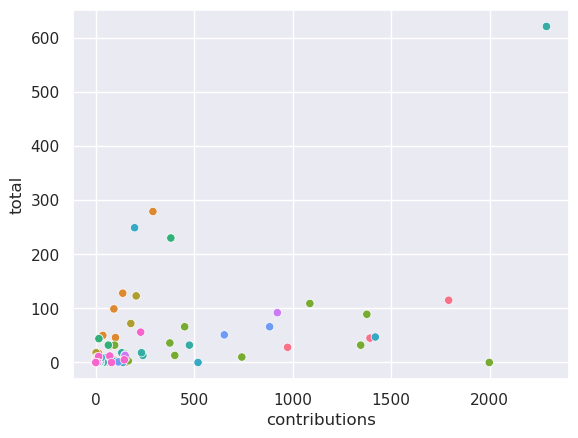

In [162]:
sns.scatterplot(data=dev_assignments, x='contributions', y='total', hue='repo_name', legend=False)

<Axes: xlabel='contributions', ylabel='total'>

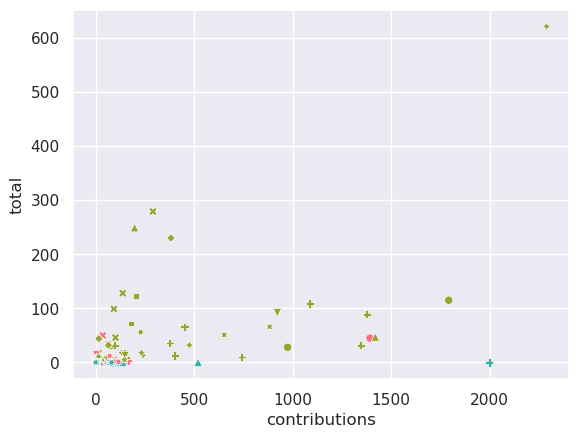

In [165]:
sns.scatterplot(data=dev_assignments, x='contributions', y='total', hue='assignment', style='repo_name', legend=False)

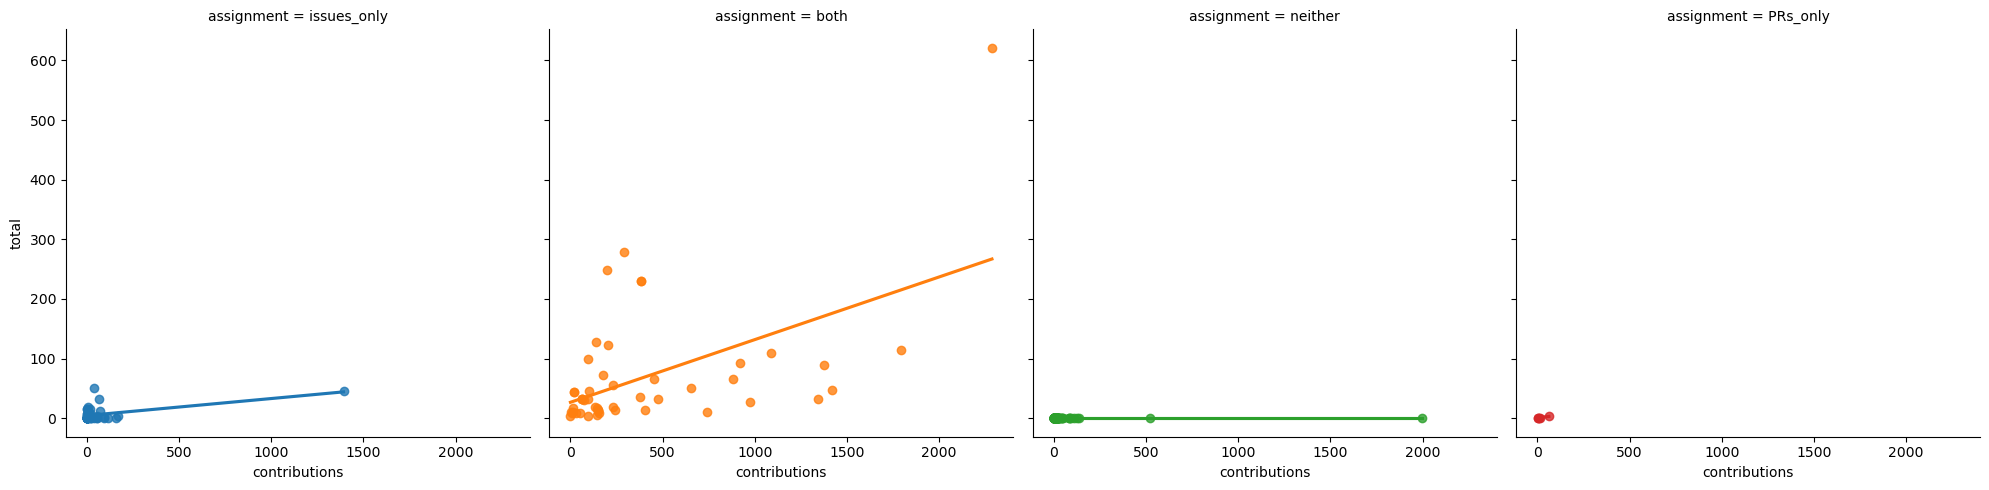

In [13]:
sns.lmplot(data=dev_assignments, x='contributions', y='total', col='assignment', hue='assignment', legend=True, ci=None)

In [117]:
#pltvalues = dev_assignments.assignment.value_counts(normalize=True)
#print(pltvalues)

category_totals = []

for item in pltvalues.values:
    print(f"~{round(item*100, 1)}%")
    #val = f"~{round(item*100)}%"
    #category_totals = category_totals.append(val)
    
#print(category_totals)

# for item in pltvalues.values:
#      print(f"~{round(item*100, 1)}%")

~57.1%
~22.4%
~18.5%
~1.9%


/home/eidf103/eidf103/flic/.conda/envs/coding-smart-github/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
/home/eidf103/eidf103/flic/.conda/envs/coding-smart-github/lib/python3.10/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'


AttributeError: 'FacetGrid' object has no attribute 'gca'

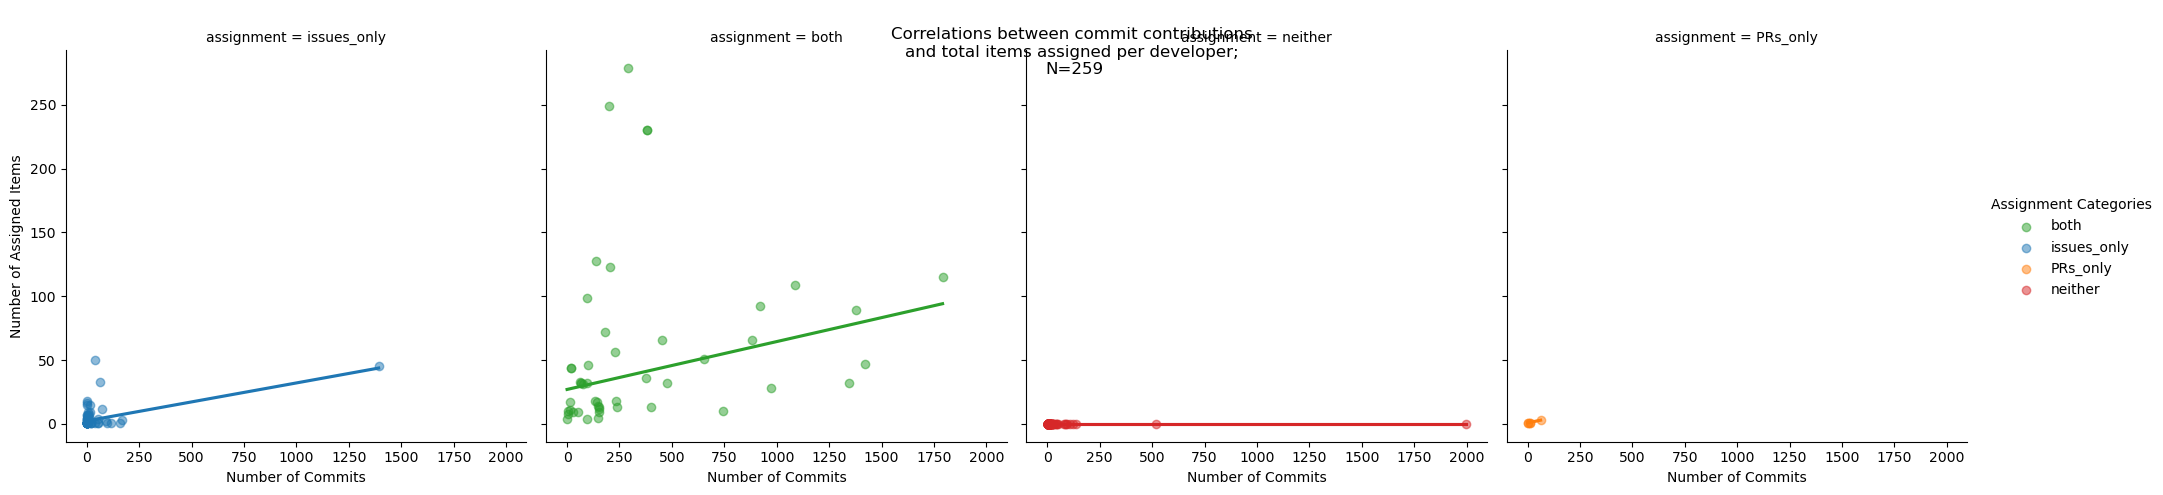

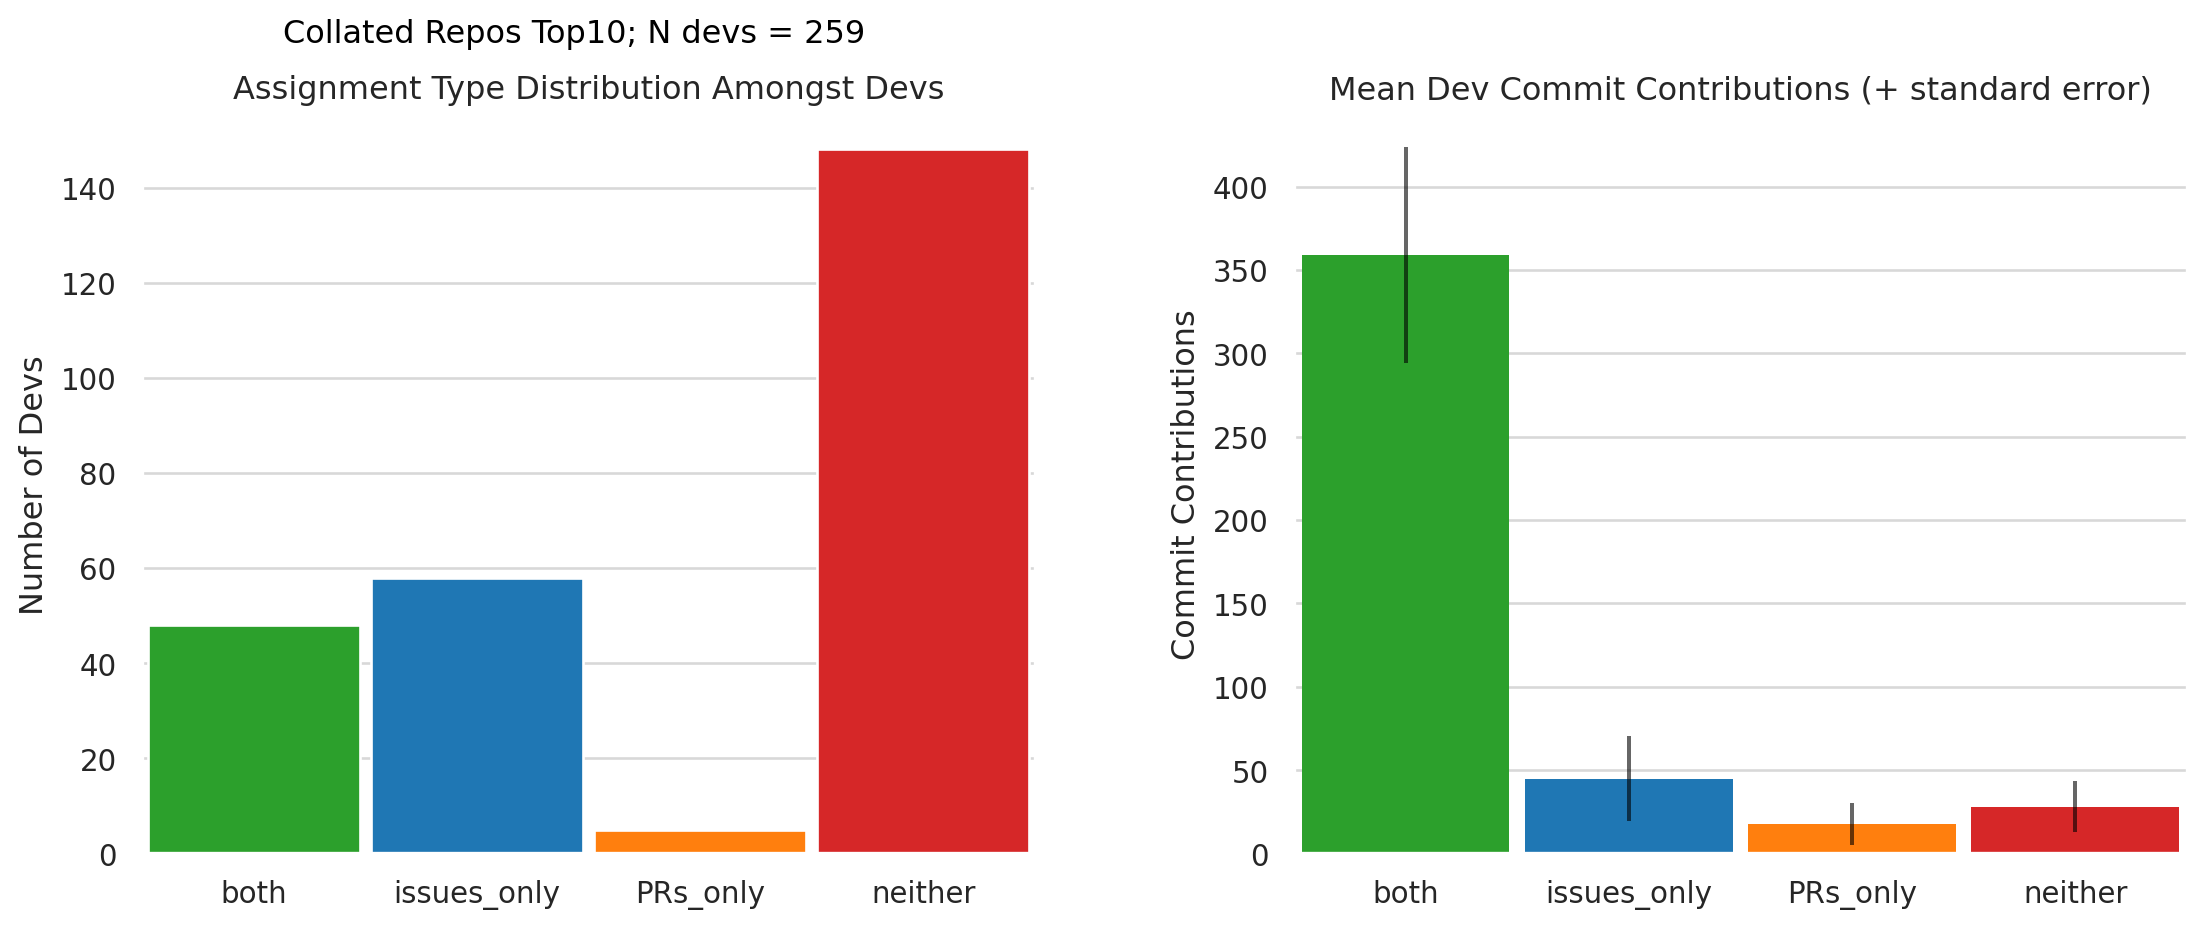

In [70]:
# throw it into the sidebyside plot from before, but working on adding a mean assignments per repo plot in the middle:

# plotting themes/colours setup
cat_order = ['both','issues_only', 'PRs_only', 'neither']
cat_palette = {'both': "#2ca02c", 'issues_only':  "#1f77b4", 'PRs_only': "#ff7f0e", 'neither': "#d62728"}
palette_list = list(cat_palette.values())

dev_assignments = dev_assignments.loc[dev_assignments['total'] < 600]

f = matplotlib.figure.Figure(figsize=(12, 5))
#sf1, sf2, sf3 = f.subfigures(1,3)
sf1, sf2 = f.subfigures(1,2)
sf1.suptitle(f'Collated Repos Top10; N devs = {len(dev_assignments.dev_name.index)}')

#f.fig.subplots_adjust(top=0.9)
# plt.fig.suptitle(f"""
# Correlations between commit contributions 
# and total items assigned per developer; 
# N={len(dev_assignments.index)}"""
# )
# plt.add_legend(title="Assignment Categories")
# plt.set_xlabels('Number of Commits', size=10)
# plt.set_ylabels('Number of Assigned Items', size=10)

(
    so.Plot(
        data=dev_assignments, 
        x='assignment',
        color='assignment' 
    )
    .add(so.Bars(width=.95, alpha=1), so.Count(), legend=False)
    .scale(x=so.Nominal(order=cat_order), color=so.Nominal(palette_list, order=cat_order), legend=False)
    .label(y='Number of Devs', x='', title="Assignment Type Distribution Amongst Devs", legend=None)
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .on(sf1)
    .plot()
)
(
    so.Plot(data=dev_assignments, x='assignment', y='contributions', color='assignment')
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.3, "axes.axisbelow":True})
    .add(so.Bar(width=.93, alpha=1), so.Agg('mean'), legend=False)
    .scale(x=so.Nominal(order=cat_order), alpha=1, color=so.Nominal(palette_list, order=cat_order), legend=False)
    .add(so.Range(color='black', alpha=0.6), so.Est(errorbar="se"), legend=None)
    .label(y='Commit Contributions', x='', title="Mean Dev Commit Contributions (+ standard error)")
    .on(sf2)
    .plot()
)

In [157]:
dev_assignments

,Unnamed: 0,dev_name,total,PRs,issues,login,type,contributions,email,name,assignment,repo_name
0,0,Chadys,1.0,0.0,1.0,Chadys,User,53.0,NaN,NaN,issues_only,devs-assignments_Axelrod-Python-Axelrod_2024-0...
1,1,Nikoleta-v3,4.0,1.0,3.0,Nikoleta-v3,User,97.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
2,2,drvinceknight,115.0,8.0,107.0,drvinceknight,User,1791.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
3,3,gaffney2010,1.0,0.0,1.0,gaffney2010,User,158.0,NaN,NaN,issues_only,devs-assignments_Axelrod-Python-Axelrod_2024-0...
4,4,marcharper,28.0,4.0,24.0,marcharper,User,974.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
...,...,...,...,...,...,...,...,...,...,...,...,...
19,28,apurvvarshney,0.0,0.0,0.0,apurvvarshney,User,2.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...
20,29,garethgeorge,0.0,0.0,0.0,garethgeorge,User,1.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...
21,30,ascientist,0.0,0.0,0.0,ascientist,User,1.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...
22,31,oliver-contier,0.0,0.0,0.0,oliver-contier,User,1.0,NaN,NaN,neither,devs-assignments_uwescience-pulse2percept_2024...


In [ ]:
(
    so.Plot(data=dev_assignments, x='assignment', y='contributions', color='assignment')
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.5, "axes.axisbelow":True})
    .add(so.Bar(width=.93, alpha=1), so.Agg('mean'), legend=False)
    .scale(x=so.Nominal(order=cat_order), alpha=1, color=so.Nominal(palette_list, order=cat_order), legend=False)
    .add(so.Range(color='black', alpha=0.6), so.Est(errorbar="se"), legend=None)
    .label(y='Commits in last year', x='Assignment Category', title="Mean Dev Commit Contributions in Last Year (+ standard error)")
    .plot()
)

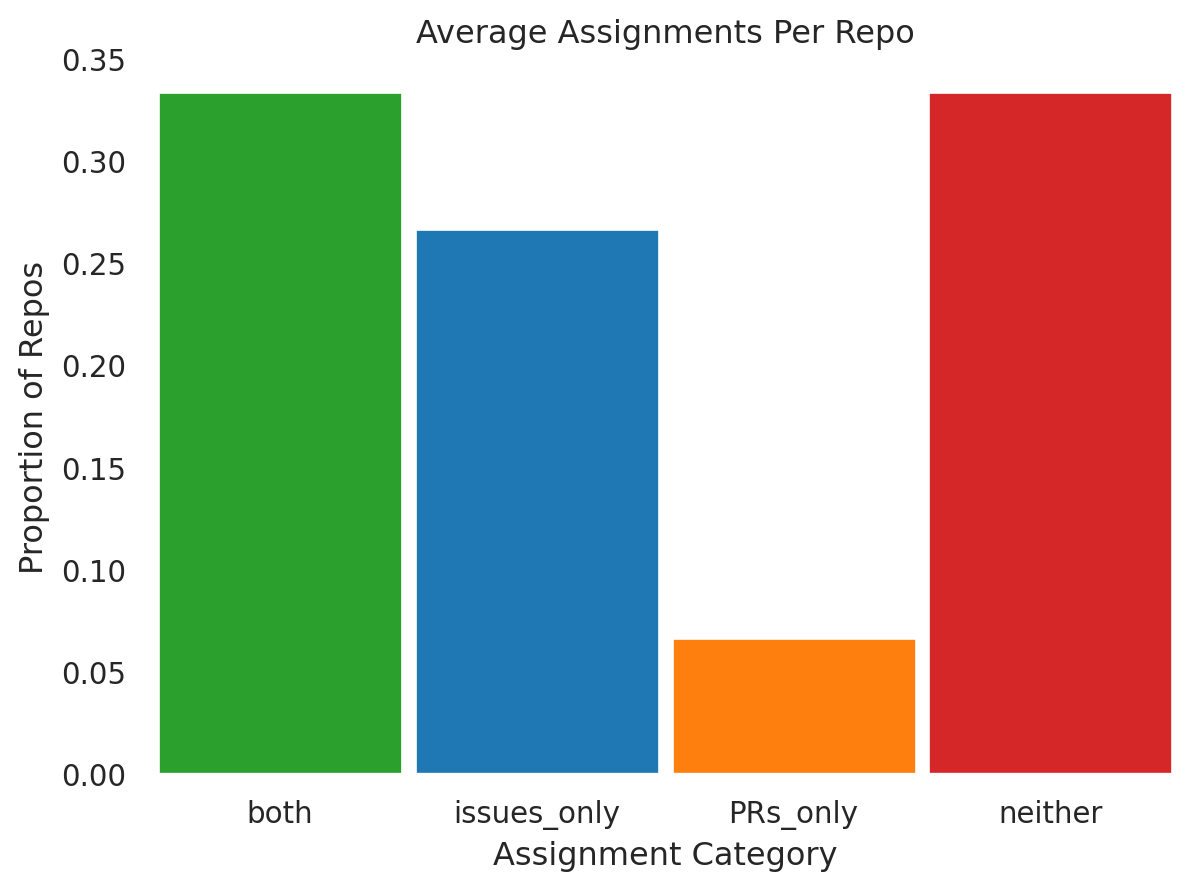

In [36]:
grouped_df = collated_df.groupby(["repo_name", "assignment"], group_keys=True)
grouped_assignments = grouped_df[['assignment']].value_counts(dropna=False)
#repo_name                                                         assignment 
#devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv            both            3
#                                                                issues_only     5
#                                                                 neither        66
#devs-assignments_CICE-Consortium-CICE_2024-03-11.csv              both            5
#                                                                 issues_only    15
#                                                                  neither         2
#devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv           both            5

counts_assignments = grouped_df[['assignment']].value_counts(dropna=False).reset_index().rename(columns={"index": "value", 0: "count"})

dev_assignments = collated_df

(
    so.Plot(
    data=counts_assignments,
    x='assignment',
    y='count',
    color='assignment' 
    )
    .add(so.Bars(width=.95, alpha=1), so.Hist(stat='proportion'), legend=False)
    .scale(x=so.Nominal(order=cat_order), color=so.Nominal(palette_list, order=cat_order), legend=False)
    .label(y='Proportion of Repos', x='Assignment Category', title="Average Assignments Per Repo", legend=None)
    .theme({"axes.facecolor": "w"})
    .plot()
)

In [87]:
print(dev_assignments)
# save out to file 
dev_assignments.to_csv("../../data/big20top10-dev_assignments_2024-03-11.csv", mode='w', index=True, header=True)

    Unnamed: 0        dev_name  total  PRs  issues           login  type  \
0            0          Chadys    1.0  0.0     1.0          Chadys  User   
1            1     Nikoleta-v3    4.0  1.0     3.0     Nikoleta-v3  User   
2            2   drvinceknight  115.0  8.0   107.0   drvinceknight  User   
3            3     gaffney2010    1.0  0.0     1.0     gaffney2010  User   
4            4      marcharper   28.0  4.0    24.0      marcharper  User   
..         ...             ...    ...  ...     ...             ...   ...   
19          28   apurvvarshney    0.0  0.0     0.0   apurvvarshney  User   
20          29    garethgeorge    0.0  0.0     0.0    garethgeorge  User   
21          30      ascientist    0.0  0.0     0.0      ascientist  User   
22          31  oliver-contier    0.0  0.0     0.0  oliver-contier  User   
23          32       subawocit    0.0  0.0     0.0       subawocit  User   

    contributions  email  name   assignment  \
0            53.0    NaN   NaN  issues_o

In [67]:
dev_assignments['assignment'].value_counts()

neither        148
issues_only     58
both            48
PRs_only         5
Name: assignment, dtype: int64

In [68]:
dev_assignments['assignment'].value_counts(normalize=True)

neither        0.571429
issues_only    0.223938
both           0.185328
PRs_only       0.019305
Name: assignment, dtype: float64

In [70]:
len(dev_assignments.index)

259

In [69]:
dev_assignments['type'].describe()

count      245
unique       2
top       User
freq       242
Name: type, dtype: object

In [94]:
dev_assignments['type'].value_counts()

User    243
Bot       3
Name: type, dtype: int64

In [103]:
tmp = dev_assignments.groupby(by='type')

tmp[['type', 'issues', 'PRs', 'total', 'contributions']].max()

,type,issues,PRs,total,contributions
type,,,,,
Bot,Bot,0.0,0.0,0.0,11.0
User,User,175.0,532.0,621.0,2287.0


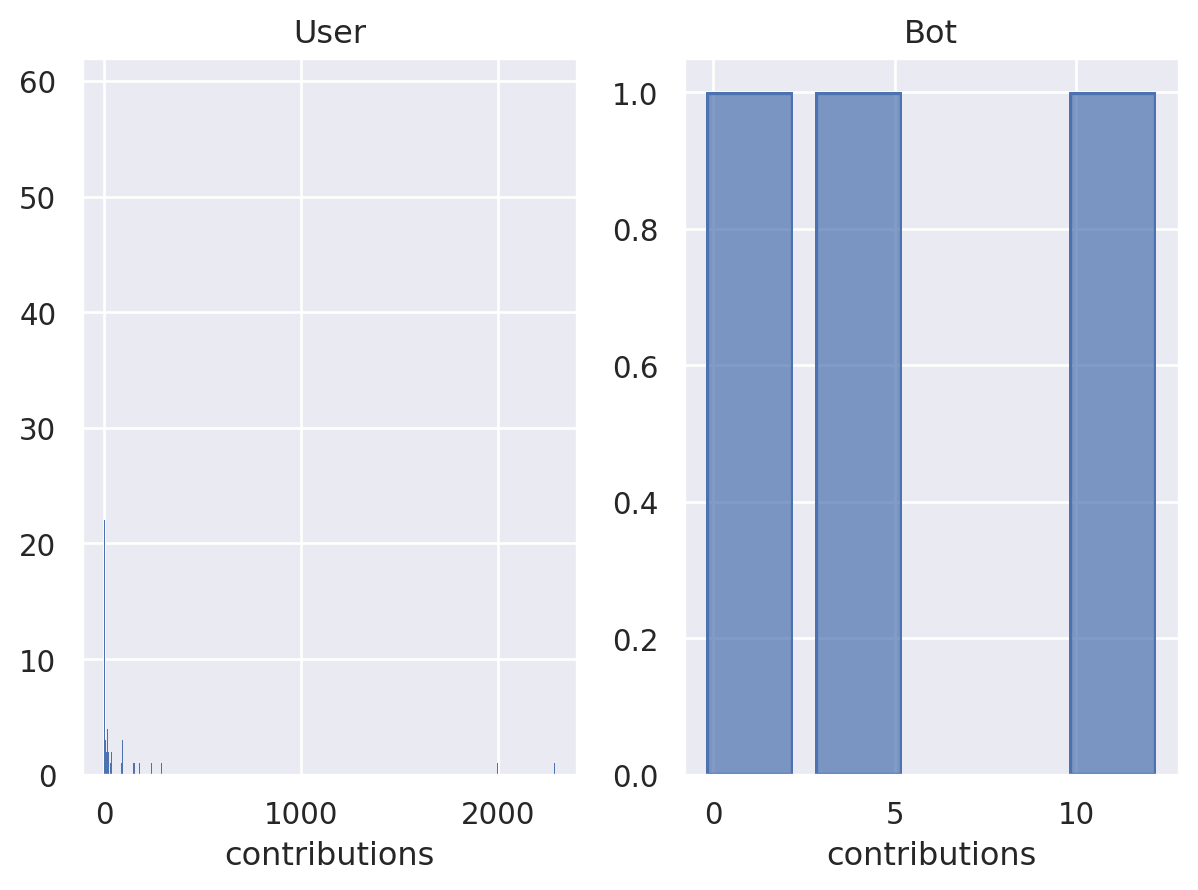

In [104]:
(
    so.Plot(
        data=dev_assignments, 
        x='contributions', 
    )
    .add(so.Bar(), so.Count())
    .facet('type')
    .share(x=False, y=False)
)


In [ ]:
# plot assigned vs unassigned numbers of items 
# plot repos using assignment vs not  
# do time windowing of measures (TODO!)

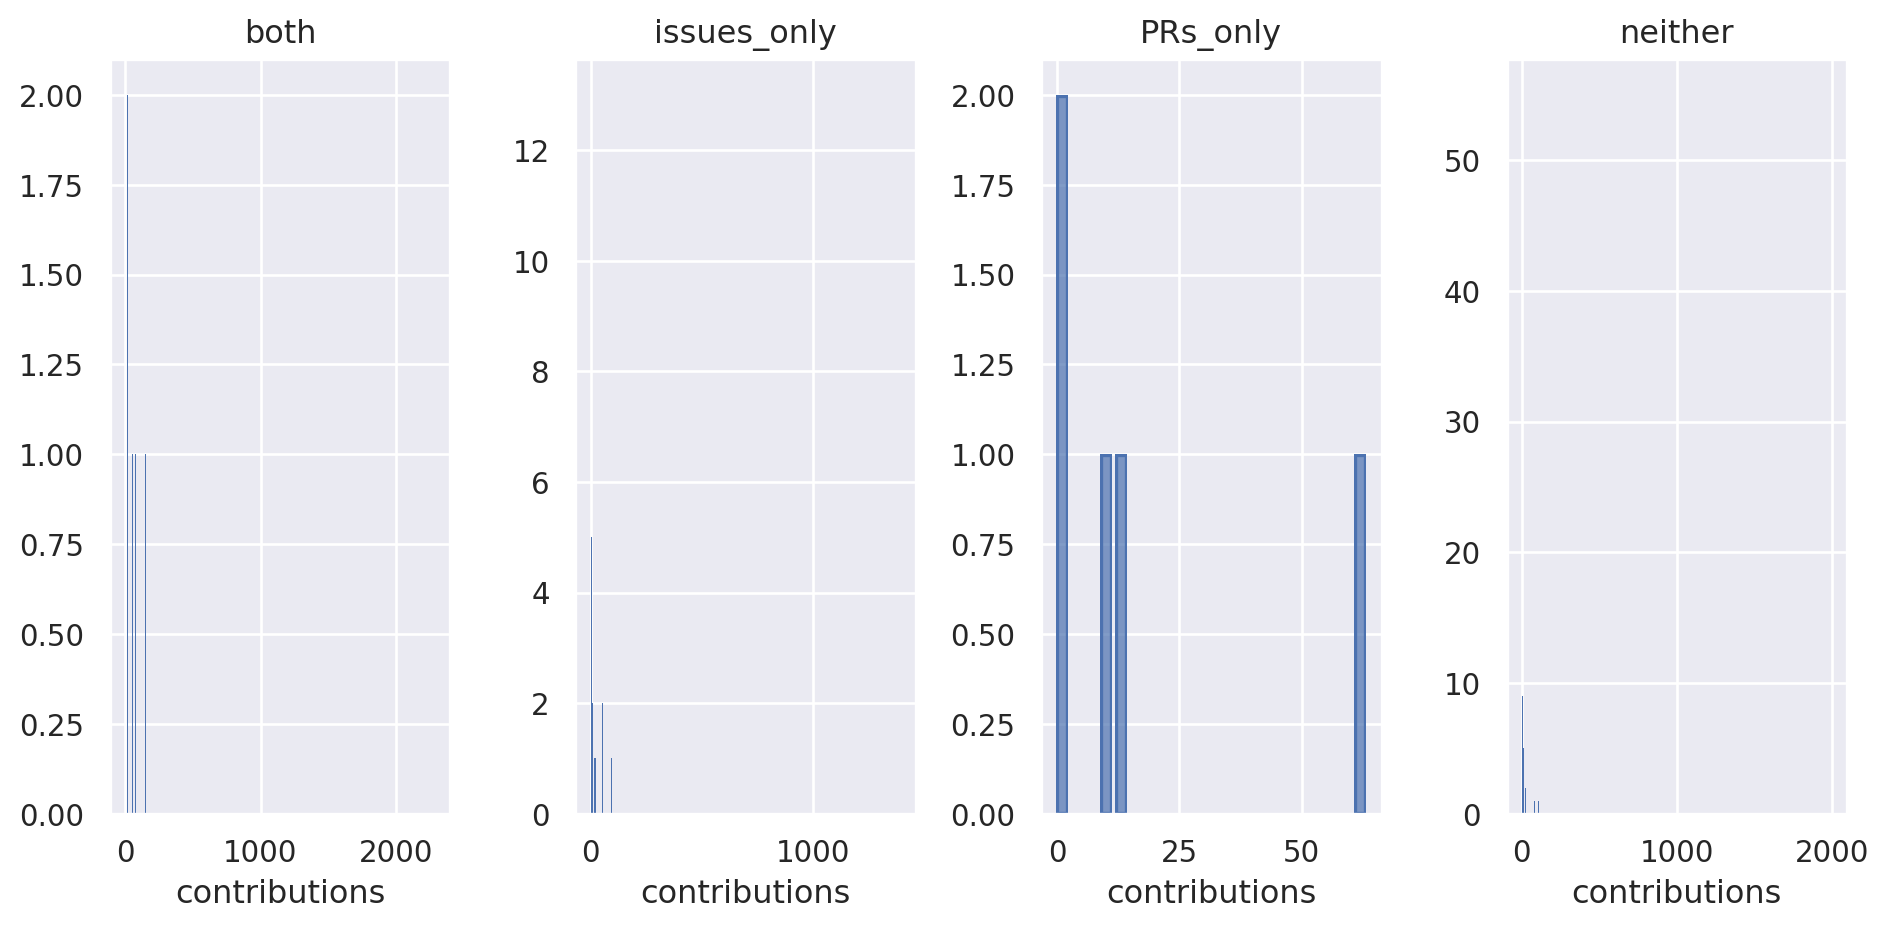

In [73]:
# plot frequency/N Devs (y) vs number of commits (x): facet/colour by assignment maybe? 

(
    so.Plot(
        data=dev_assignments,
        x='contributions'
        #color='assignment' 
    )
    .layout(size=(10,5))
    .add(so.Bar(), so.Count())
    .facet('assignment', order=cat_order)
    .share(x=False, y=False)
)


In [75]:
dev_assignments_issues_only = dev_assignments[dev_assignments['assignment']=='issues_only']
dev_assignments_issues_only.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,58.000000,58.000000,58.0,58.000000,58.000000,0.0,0.0
mean,7.241379,5.793103,0.0,5.793103,44.827586,NaN,NaN
std,5.436428,9.801107,0.0,9.801107,183.903783,NaN,NaN
min,0.000000,1.000000,0.0,1.000000,0.000000,NaN,NaN
25%,3.000000,1.000000,0.0,1.000000,1.000000,NaN,NaN
50%,6.000000,2.000000,0.0,2.000000,3.000000,NaN,NaN
75%,11.000000,6.000000,0.0,6.000000,20.500000,NaN,NaN
max,20.000000,50.000000,0.0,50.000000,1392.000000,NaN,NaN


In [76]:
dev_assignments_PRs_only = dev_assignments[dev_assignments['assignment']=='PRs_only']
dev_assignments_PRs_only.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,5.000000,5.000000,5.000000,5.0,5.00000,0.0,0.0
mean,5.400000,1.400000,1.400000,0.0,17.40000,NaN,NaN
std,4.722288,0.894427,0.894427,0.0,25.50098,NaN,NaN
min,0.000000,1.000000,1.000000,0.0,1.00000,NaN,NaN
25%,1.000000,1.000000,1.000000,0.0,1.00000,NaN,NaN
50%,7.000000,1.000000,1.000000,0.0,10.00000,NaN,NaN
75%,8.000000,1.000000,1.000000,0.0,13.00000,NaN,NaN
max,11.000000,3.000000,3.000000,0.0,62.00000,NaN,NaN


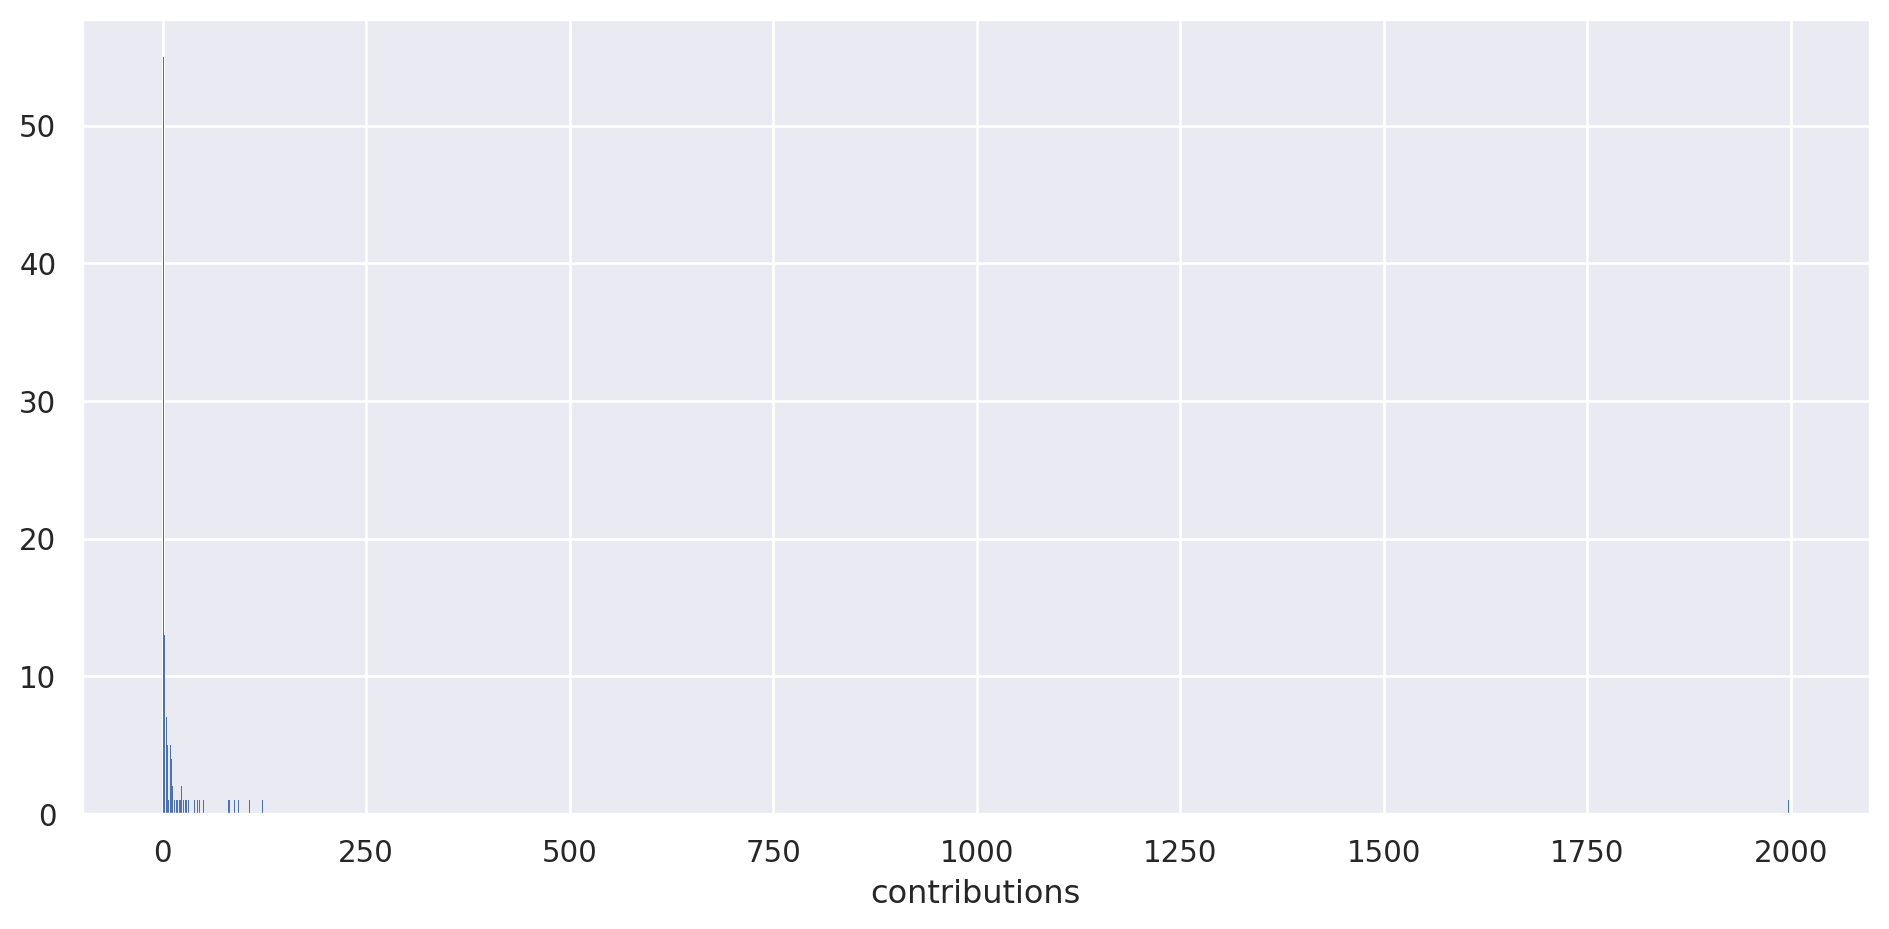

In [55]:
# plot frequency/N Devs (y) vs number of commits (x): facet/colour by assignment maybe? 
dev_assignments_neither = dev_assignments[dev_assignments['assignment']=='neither']

(
    so.Plot(
        data=dev_assignments_neither,
        x='contributions'
        #color='assignment' 
    )
    .layout(size=(10,5))
    .add(so.Bar(), so.Count())
)

In [59]:
dev_assignments_neither.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,148.000000,148.0,148.0,148.0,148.000000,0.0,0.0
mean,34.641892,0.0,0.0,0.0,28.081081,NaN,NaN
std,20.065542,0.0,0.0,0.0,169.734307,NaN,NaN
min,7.000000,0.0,0.0,0.0,1.000000,NaN,NaN
25%,20.750000,0.0,0.0,0.0,1.000000,NaN,NaN
50%,29.000000,0.0,0.0,0.0,3.000000,NaN,NaN
75%,46.250000,0.0,0.0,0.0,10.000000,NaN,NaN
max,83.000000,0.0,0.0,0.0,1997.000000,NaN,NaN


In [62]:
dev_assignments_neither.sort_values(by=['contributions'], ascending=False)

,Unnamed: 0,dev_name,total,PRs,issues,login,type,contributions,email,name,assignment,repo_name
19,20,pyup-bot,0.0,0.0,0.0,pyup-bot,User,1997.0,NaN,NaN,neither,devs-assignments_Dallinger-Dallinger_2024-03-1...
6,7,tsj5,0.0,0.0,0.0,tsj5,User,520.0,NaN,NaN,neither,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...
7,8,yihungkuo,0.0,0.0,0.0,yihungkuo,User,138.0,NaN,NaN,neither,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...
8,9,eric-s-s,0.0,0.0,0.0,eric-s-s,User,123.0,NaN,NaN,neither,devs-assignments_Axelrod-Python-Axelrod_2024-0...
9,10,janga1997,0.0,0.0,0.0,janga1997,User,107.0,NaN,NaN,neither,devs-assignments_Axelrod-Python-Axelrod_2024-0...
...,...,...,...,...,...,...,...,...,...,...,...,...
27,33,cwsmith,0.0,0.0,0.0,cwsmith,User,1.0,NaN,NaN,neither,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
28,34,mattdturner,0.0,0.0,0.0,mattdturner,User,1.0,NaN,NaN,neither,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
29,35,dengwirda,0.0,0.0,0.0,dengwirda,User,1.0,NaN,NaN,neither,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
11,14,cmbitz,0.0,0.0,0.0,cmbitz,User,1.0,NaN,NaN,neither,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...


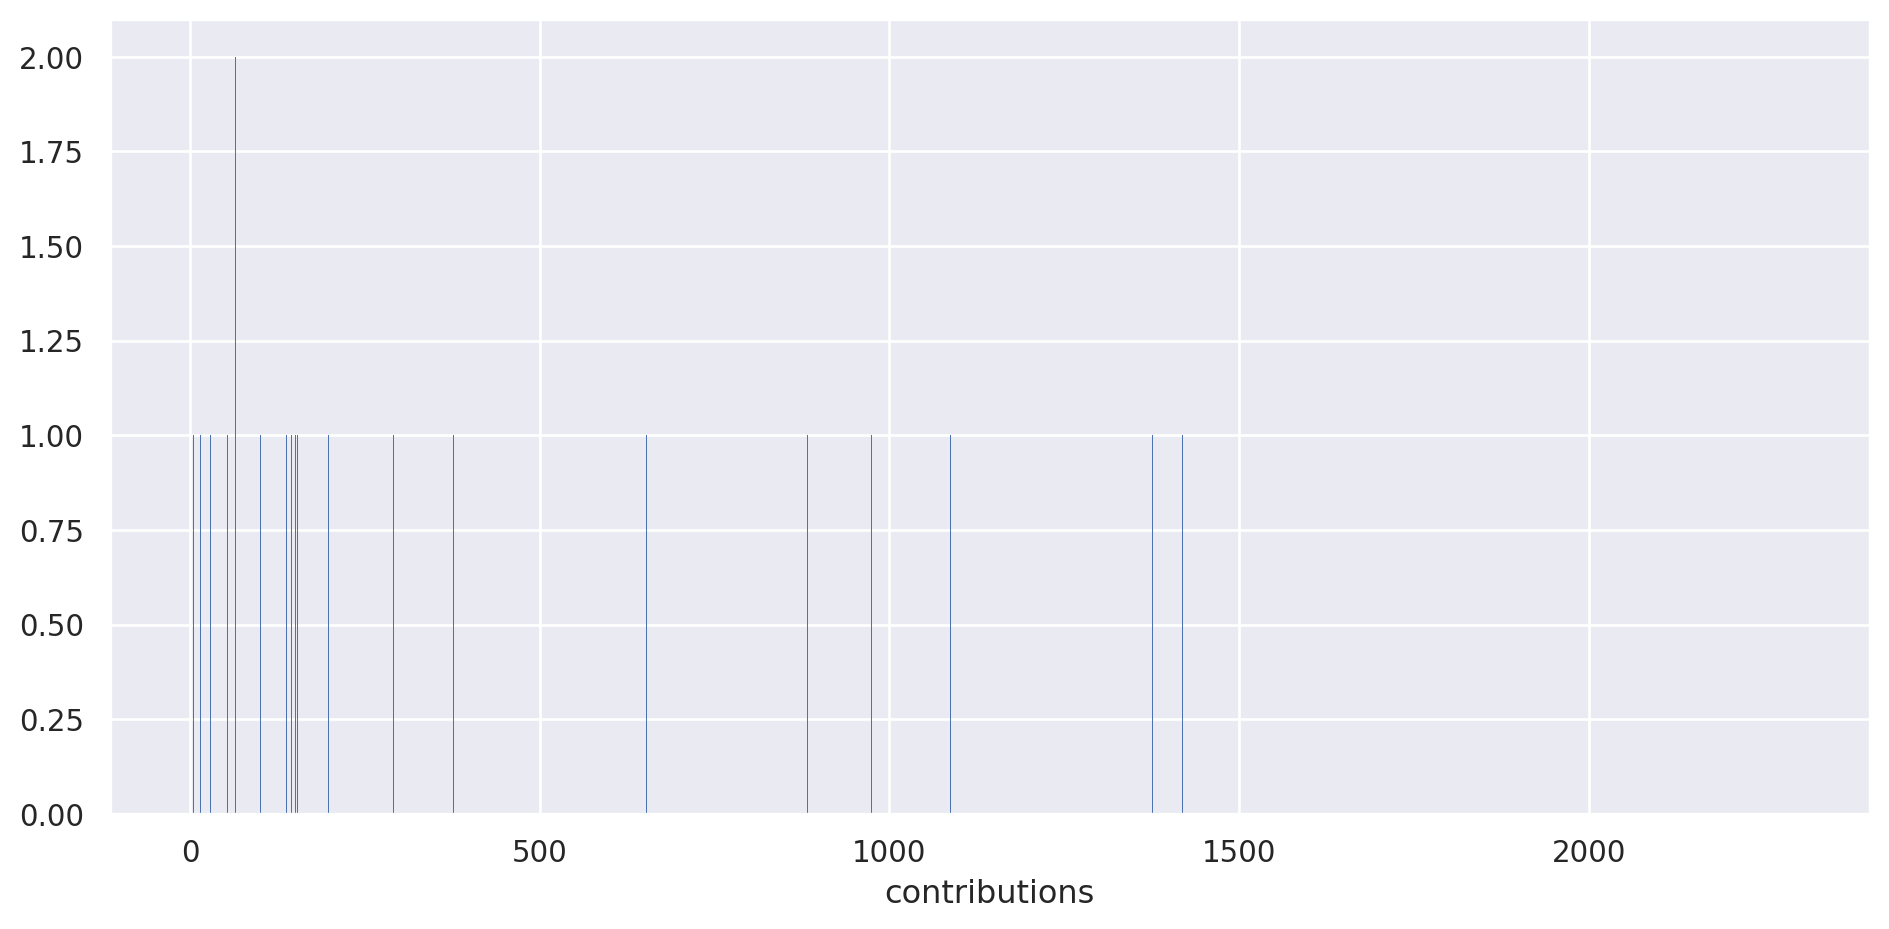

In [78]:
dev_assignments_both = dev_assignments[dev_assignments['assignment']=='both']

(
    so.Plot(
        data=dev_assignments_both,
        x='contributions'
        #color='assignment' 
    )
    .layout(size=(10,5))
    .add(so.Bar(), so.Count())
)

In [67]:
dev_assignments_both.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,49.000000,49.000000,49.000000,49.000000,49.000000,0.0,0.0
mean,6.408163,68.530612,34.000000,34.530612,398.122449,NaN,NaN
std,5.171711,104.462932,82.545694,37.617096,515.279359,NaN,NaN
min,0.000000,4.000000,1.000000,1.000000,0.000000,NaN,NaN
25%,2.000000,13.000000,2.000000,8.000000,76.000000,NaN,NaN
50%,5.000000,32.000000,8.000000,20.000000,154.000000,NaN,NaN
75%,10.000000,72.000000,24.000000,50.000000,452.000000,NaN,NaN
max,19.000000,621.000000,532.000000,175.000000,2287.000000,NaN,NaN


In [66]:
dev_assignments_both.sort_values(by=['contributions'], ascending=False)

,Unnamed: 0,dev_name,total,PRs,issues,login,type,contributions,email,name,assignment,repo_name
14,15,xylar,621.0,532.0,89.0,xylar,User,2287.0,NaN,NaN,both,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
2,2,drvinceknight,115.0,8.0,107.0,drvinceknight,User,1791.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
4,4,tsjackson-noaa,47.0,13.0,34.0,tsjackson-noaa,User,1419.0,NaN,NaN,both,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...
9,9,jessesnyder,89.0,10.0,79.0,jessesnyder,User,1376.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...
14,14,suchow,32.0,6.0,26.0,suchow,User,1345.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...
6,6,fmhoeger,109.0,76.0,33.0,fmhoeger,User,1087.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...
4,4,marcharper,28.0,4.0,24.0,marcharper,User,974.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
1,1,kinverarity1,92.0,10.0,82.0,kinverarity1,User,922.0,NaN,NaN,both,devs-assignments_kinverarity1-lasio_2024-03-11...
0,0,ayllon,66.0,10.0,56.0,ayllon,User,883.0,NaN,NaN,both,devs-assignments_astrorama-SourceXtractorPlusP...
15,15,thomasmorgan,10.0,2.0,8.0,thomasmorgan,User,742.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...


In [47]:
# total number of distinct devs
dev_assignments['dev_name'].nunique()

235

In [49]:
# total number of dev name entries
dev_assignments['dev_name'].count()

260

In [84]:
for name in dev_assignments['dev_name'].sort_values():
    print(name)

314pe
ABarriscale
AdamPohl
CamDavidsonPilon
Chadys
Conrad-Crowley
DallingerBot
DavidCEllis
DeniseWorthen
Dubath
DylanLin29
ElineVG
Epsiilon
FakeNameSE
FrancieNagiki
Fry484
GDKO
GGOUSSEAUD
GNellyEmlaw
HKaras
HKaras
Inviro
JFLemieux73
JFLemieux73
JasYoung315
JustinGOSSES
Jyhess
Karlos78
Luke-Poeppel
MHakem
MXB6669
MandarJKulkarni
MariosZoulias
MatthewWilkes
MichaelWinton
NeuroscienceScripts
Nikoleta-v3
RobPDev
RomeroLaura
TillRasmussen
TillRasmussen
VartanAhrensKayayan
VelizarVESSELINOV
WadeVaresio
Wen-hao-Dong
WonkySpecs
a-paxton
abouchat
adamwulf
ae3e
ahbutlerwx
aiwenxu
akash-suresh
akturner
alcarney
alecpm
alexhroom
alicebarthel
altheaden
amkratz
anders-dc
anders-dc
andrewdnolan
anton-seaice
apcraig
apcraig
apurvvarshney
aradhakrishnanGFDL
architSrivastav
areebahmed04
arokem
ascientist
aseyq
ayllon
ben-harack
bgschaid
bitterbark
bootandy
bradyrx
bricef
buckbaskin
caddycarine
caozd999
cbegeman
ceblanton
cewing
cguardia
chiruzzimarco
chrisknewman
cmbitz
connortann
cwsmith
dabail10
dabai

## Try to subset data within standard deviation of contributions? 

In [108]:
dev_assignments.std(skipna=True, ddof=1, numeric_only=True)

Unnamed: 0        20.768205
total             52.308806
PRs               37.947021
issues            21.340374
contributions    305.930388
email                   NaN
name                    NaN
dtype: float64

In [171]:
grp = dev_assignments.groupby(by=['assignment'])
grp.std(ddof=1, numeric_only=True)

,Unnamed: 0,total,PRs,issues,contributions,email,name
assignment,,,,,,,
PRs_only,4.722288,0.894427,0.894427,0.000000,25.500980,NaN,NaN
both,5.171711,104.462932,82.545694,37.617096,515.279359,NaN,NaN
issues_only,5.436428,9.801107,0.000000,9.801107,183.903783,NaN,NaN
neither,20.065542,0.000000,0.000000,0.000000,169.734307,NaN,NaN


PRs_only            Axes(0.1,0.559091;0.363636x0.340909)
both           Axes(0.536364,0.559091;0.363636x0.340909)
issues_only             Axes(0.1,0.15;0.363636x0.340909)
neither            Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

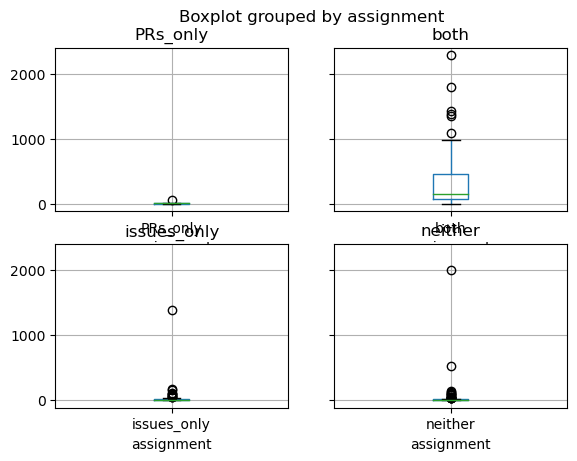

In [169]:
grp.boxplot(column='contributions', by='assignment')

/tmp/ipykernel_245043/2114290744.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grp.boxplot(column='total', by='assignment')


PRs_only            Axes(0.1,0.559091;0.363636x0.340909)
both           Axes(0.536364,0.559091;0.363636x0.340909)
issues_only             Axes(0.1,0.15;0.363636x0.340909)
neither            Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

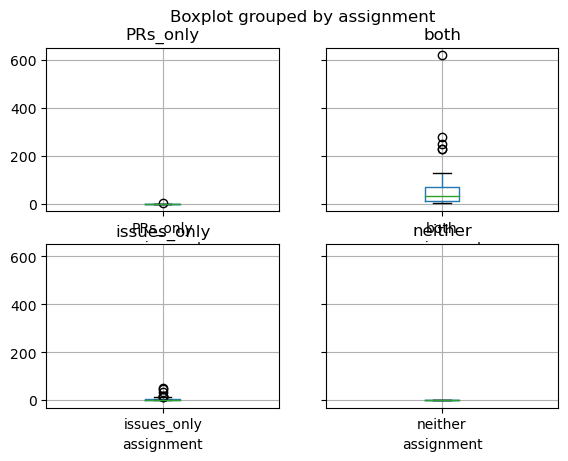

In [172]:
grp.boxplot(column='total', by='assignment')

## Try an ANOVA to check for differences between the assignment groups in contributions 

In [ ]:
# based on the details for scipy stats, ANOVA only works if you satisfy assumptions: 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html 

#The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.
  #The samples are independent.
  #Each sample is from a normally distributed population.
  #The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

# So I'd need to ensure that those are true for my data  
# BUT based on above, the standard deviations are not equal for my groups in either total or contributions...

# Can I transform the data to ensure it meets these criteria?
# Alternatively I may need to try the Kruskal-Wallis H test or the AlexanderGovern one 

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.alexandergovern.html#scipy.stats.alexandergovern

In [165]:
import scipy.stats as stats

# TOTES INAPPROPES ANOVA: 

# method via: https://www.geeksforgeeks.org/how-to-perform-a-one-way-anova-in-python/ 

# group data by 'assignment' 
contributions_frame = dev_assignments[['assignment', 'contributions']]

# extract groups 
both = dev_assignments_both['contributions'] 
issues_only = dev_assignments_issues_only['contributions'] 
PRs_only = dev_assignments_PRs_only['contributions'] 
neither = dev_assignments_neither['contributions']  

#print(both)
#print(".....")
#print(neither)

stats.f_oneway(both, issues_only, PRs_only, neither)
#F_onewayResult(statistic=24.055169942343, pvalue=9.530611358655972e-14) # lol 

stats.f_oneway(both, neither)
#F_onewayResult(statistic=57.889273187426795, pvalue=1.1536029211348295e-12) # whelp. D:

F_onewayResult(statistic=57.889273187426795, pvalue=1.1536029211348295e-12)

In [166]:
stats.kruskal(both, neither)
# KruskalResult(statistic=84.06772721806304, pvalue=4.781120466931489e-20)  # Hmmm

KruskalResult(statistic=84.06772721806304, pvalue=4.781120466931489e-20)

ValueError: `popmean.shape[axis]` must equal 1.

## Trying a Tukey Test to compare the pairs of groups for TOTAL ASSIGNMENTS 

Testing assignment groups vs Total items assigned


group1,group2,meandiff,p-adj,lower,upper,reject
PRs_only,both,67.1306,0.01,11.9277,122.3335,True
PRs_only,issues_only,4.3931,0.9968,-50.4118,59.198,False
PRs_only,neither,-1.4,0.9999,-54.8661,52.0661,False
both,issues_only,-62.7375,0.0,-85.5529,-39.9221,True
both,neither,-68.5306,0.0,-87.9106,-49.1507,True
issues_only,neither,-5.7931,0.8438,-24.0084,12.4222,False


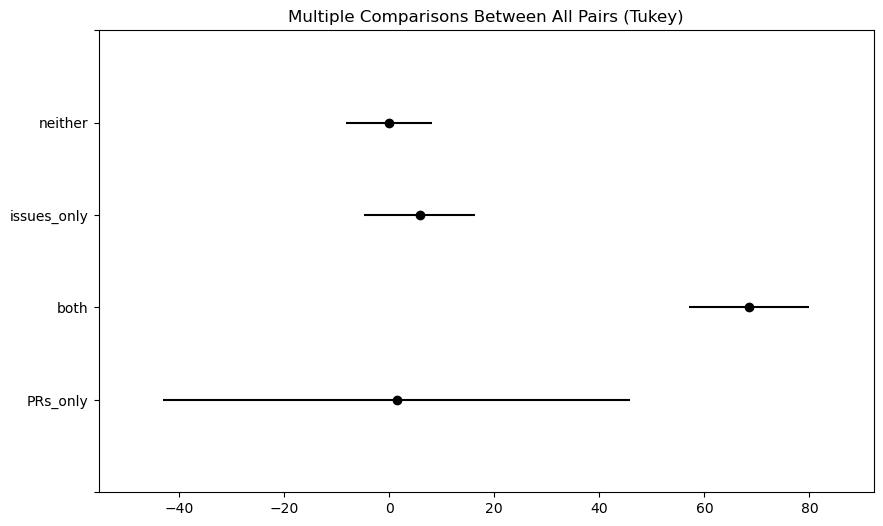

In [163]:
totals = dev_assignments.total
#totals

assignments = dev_assignments.assignment
#assignments

from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("Testing assignment groups vs Total items assigned")

tukey_total = pairwise_tukeyhsd(endog=totals, groups=assignments, alpha=0.05)

tukey_total.plot_simultaneous()

tukey_total.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
PRs_only,both,380.7224,0.0164,50.759,710.6859,True
PRs_only,issues_only,27.4276,0.9964,-300.1569,355.012,False
PRs_only,neither,10.6811,0.9998,-308.9006,330.2628,False
both,issues_only,-353.2949,0.0,-489.669,-216.9208,True
both,neither,-370.0414,0.0,-485.8808,-254.202,True
issues_only,neither,-16.7465,0.9786,-125.6247,92.1317,False


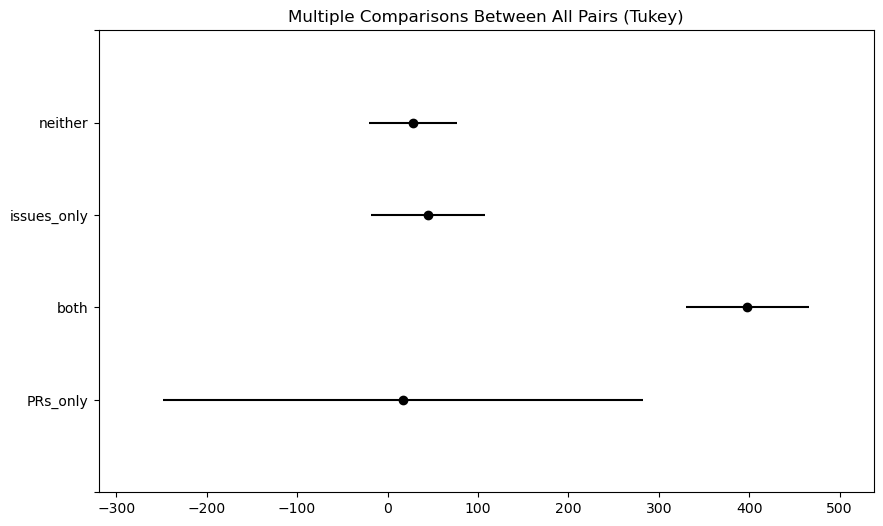

In [162]:
contributionses = dev_assignments.contributions
#contributionses

#print("Testing assignment groups vs commit contributions")
tukey_contribs = pairwise_tukeyhsd(endog=contributionses, groups=assignments, alpha=0.05)

tukey_contribs.plot_simultaneous()

tukey_contribs.summary()

### There are devs in multiple repos here.  

## 1 Repo Version of Poster Plot

In [5]:
#repo_name = 'MotionbyLearning/stm' # 61
#repo_name = 'JeschkeLab/DeerLab'
repo_name = 'Axelrod-Python/Axelrod'

import githubanalysis.processing.get_all_pages_issues
from githubanalysis.processing.get_all_pages_issues import IssueGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_NOTEBOOK_logs.txt')  
issues_getter = IssueGetter(logger)

iss_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')

INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 1 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 2 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 3 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 4 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 5 of 5.


In [6]:
import githubanalysis.processing.get_repo_contributors
from githubanalysis.processing.get_repo_contributors import DevsGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_repo_contributors_NOTEBOOK_logs.txt')  
devs_getter = DevsGetter(logger)

devs_df = devs_getter.get_repo_contributors(repo_name=repo_name, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')

INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo JeschkeLab/DeerLab.


Text(0.5, 1.0, 'Assignment Types amongst (non-Anonymous) Developers in JeschkeLab/DeerLab repo')

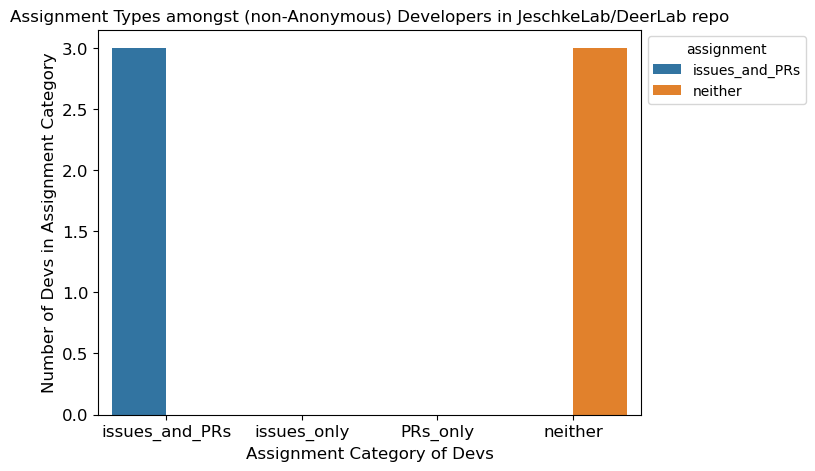

In [7]:
from ast import literal_eval

repo_name = 'JeschkeLab/DeerLab'
issues_data = '../../data/all-issues_JeschkeLab-DeerLab_2024-03-11.csv'
contributors_file = "../../data/contributors_JeschkeLab-DeerLab_2024-03-11.csv"

# read in dataset, explode to deal with multiple assignments on same item  
issues_df = pd.read_csv(issues_data, header=0) 

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned') 

# group by dev
grouped = exploded_devs.groupby('assigned_devs')

all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    #print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}

all_devs_df = pd.DataFrame.from_dict(all_devs)

# read in contributors data and rename 'login' field as 'dev_name' as later joining key  
contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df['dev_name'] = contributors_df['login']

# do outer join on both issues and contributors datasets on dev_name column (full outer join so we don't lose any devs not in other df)    
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

# drop extra columns brought in from contributors dataset  
joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'login', 'type', 'contributions', 'email', 'name']]

# fill columns from all_devs_df with 0s for newly added devs w/o assignments info from other table    
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] > 1) & (joinage['issues'] > 1),
    (joinage['PRs'] == 0) & (joinage['issues'] > 1),
    (joinage['PRs'] > 1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

# remove non-named-dev entries from joined dataset  
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

#  | dev_name | total | PRs | issues | assignment | login | type | contributions | email | name
# -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | --
# HKaras | 22.0 | 12.0 | 10.0 | issues_and_PRs | HKaras | User | 17.0 | NaN | NaN
# luisfabib | 115.0 | 67.0 | 48.0 | issues_and_PRs | luisfabib | User | 382.0 | NaN | NaN
# stestoll | 16.0 | 14.0 | 2.0 | issues_and_PRs | stestoll | User | 65.0 | NaN | NaN
# mtessmer | 0.0 | 0.0 | 0.0 | neither | mtessmer | User | 14.0 | NaN | NaN
# laenan8466 | 0.0 | 0.0 | 0.0 | neither | laenan8466 | User | 1.0 | NaN | NaN
# edmundxcvi | 0.0 | 0.0 | 0.0 | neither | edmundxcvi | User | 1.0 | NaN | NaN

# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")

In [ ]:
# Bigger Different Repo: 

from ast import literal_eval

repo_name = 'Dallinger/Dallinger'
issues_data = '../../data/all-issues_Dallinger-Dallinger_2024-02-27.csv'
contributors_file = "../../data/contributors_Dallinger-Dallinger_2024-02-27.csv"

# read in dataset, explode to deal with multiple assignments on same item  
issues_df = pd.read_csv(issues_data, header=0) 

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned') 

# group by dev
grouped = exploded_devs.groupby('assigned_devs')

all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    #print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}

all_devs_df = pd.DataFrame.from_dict(all_devs)

# read in contributors data and rename 'login' field as 'dev_name' as later joining key  
contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df['dev_name'] = contributors_df['login']

# do outer join on both issues and contributors datasets on dev_name column (full outer join so we don't lose any devs not in other df)    
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

# drop extra columns brought in from contributors dataset  
joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'login', 'type', 'contributions', 'email', 'name']]

# fill columns from all_devs_df with 0s for newly added devs w/o assignments info from other table    
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] >= 1) & (joinage['issues'] >= 1),
    (joinage['PRs'] == 0) & (joinage['issues'] >=1),
    (joinage['PRs'] >=1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

# remove non-named-dev entries from joined dataset  
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")

print(joinage)

current_date_info = datetime.now().strftime("%Y-%m-%d") # run this at start of script not in loop to avoid midnight/long-run issues
sanitised_repo_name = repo_name.replace("/", "-")
write_out = f'../../data/all-devs-assigned_{sanitised_repo_name}'
write_out_extra_info = f"{write_out}_{current_date_info}.csv" 

joinage.to_csv(write_out_extra_info, mode='w', index=True, header=True)

In [ ]:
joinage['assignment'].value_counts()

In [ ]:
joinage['assignment'].value_counts()['issues_only']

In [ ]:
repo_name = 'JeschkeLab/DeerLab'
issues_data = '../../data/all-issues_JeschkeLab-DeerLab_2024-02-22.csv'

issues_df = pd.read_csv(issues_data, header=0) 

print(issues_df.shape)
print(len(issues_df.index))
print(issues_df[issues_df.index==60])

In [ ]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2

from ast import literal_eval

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')  

print(exploded_devs.shape)
print(len(exploded_devs.index))
print(exploded_devs[exploded_devs.index==60])

In [ ]:
# this works now due to the literal_eval apply via SO: https://stackoverflow.com/a/63589387 
exploded_devs['assigned_devs'].value_counts(dropna=False)

In [ ]:
# corroboration of those assignments
exploded_devs.groupby('assigned_devs').count()

In [ ]:
grouped = exploded_devs.groupby('assigned_devs')

for name, group in grouped:  # via https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#iterating-through-groups
    print(f"Dev: {name}")
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    print(f"  Total assignments: {total_recs}") # using ID since it's guaranteed to be filled 
    print(f"  PRs: {total_PRs}")
    print(f"  Issues: {total_recs - total_PRs}")

In [ ]:
dev_dict = {}

dev_dict.update({'dev_name': name})
dev_dict.update({'total': total_recs})
dev_dict.update({'PRs': total_PRs})
dev_dict.update({'issues': total_recs - total_PRs})

print(dev_dict)

In [ ]:
all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}
    
print(all_devs)

all_devs_df = pd.DataFrame.from_dict(all_devs)
print(all_devs_df.shape)
print(all_devs_df)

In [ ]:
# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (all_devs_df['PRs'] > 1) & (all_devs_df['issues'] > 1),
    (all_devs_df['PRs'] == 0) & (all_devs_df['issues'] > 1),
    (all_devs_df['PRs'] > 1) & (all_devs_df['issues'] == 0),
    (all_devs_df['PRs'] == 0) & (all_devs_df['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
all_devs_df['assignment'] = np.select(conditions, choices, default='error')
print(all_devs_df)

# method via https://stackoverflow.com/a/19913845 

In [ ]:
all_devs_df

In [ ]:
all_devs_df_melt = pd.melt(all_devs_df, id_vars=['dev_name', 'assignment'], var_name='assigned_to', value_vars=['issues', 'PRs'], value_name='assignment_counts')
all_devs_df_melt

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.catplot(
    data=all_devs_df_melt, 
    x='dev_name',
    y='assignment_counts',
    hue='assigned_to', 
    kind='bar',
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index
)
all_tix=all_devs_df_melt.assignment_counts.sum()
plt.xticks(size=12)
plt.xlabel('Assigned To Dev', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets/PRs Assigned to Dev', size=12)
plt.title(f"Issue Ticket and Pull Request Assignment amongst Developers in {repo_name} repo:  N = {all_tix}")

In [ ]:
all_devs_df['assignment'] = all_devs_df['assignment'].astype('category')

all_devs_df.dtypes


In [ ]:
all_devs_df['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

In [ ]:
# make assignment a category datatype
all_devs_df['assignment'] = all_devs_df['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
all_devs_df['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=all_devs_df, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst Developers in {repo_name} repo")

## TODO:  
  # remove 'unassigned' from the counts for this plot  
  # see if it works for repos with differing assignments  
  # add non-assigned devs from 'contributors' data  
  # create a specific colour palette for issues (blue), PRs (orange), issues & PRs (?both?), and neither (grey?)    



In [ ]:
# read in contributors data: 
contributors_file = "../../data/contributors_JeschkeLab-DeerLab_2024-02-27.csv"

contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df

In [ ]:
for dev in contributors_df['login']: 
    print(all_devs_df['dev_name'].str.contains(str(dev), regex=False))
    

In [ ]:
for dev in all_devs_df['dev_name']:
    print(dev)

In [ ]:
type(contributors_df['login'])

In [ ]:
contributors_df['login'].str.contains('HKaras')

In [ ]:
all_devs_df['dev_name']

In [ ]:
contributors_df['dev_name'] = contributors_df['login']
contributors_df

In [ ]:
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'assignment', 'login', 'type', 'contributions', 'email', 'name']]

In [ ]:
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)
#joinage['dev_name'] = joinage['dev_name'].fillna(value='Anonymous')

#print(joinage)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] > 1) & (joinage['issues'] > 1),
    (joinage['PRs'] == 0) & (joinage['issues'] > 1),
    (joinage['PRs'] > 1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

print(joinage)


In [ ]:
joinage.dtypes

In [ ]:
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

joinage

In [ ]:
# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")


In [ ]:
plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assignment', 
    hue='value',
    data=pd.melt(joinage) 
    #order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
# plt.xticks(size=12)
# plt.xlabel('Assigned To User', size=12)
# plt.yticks(size=12)
# plt.ylabel('Count of Tickets Assigned', size=12)
# #plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
# plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")

In [ ]:
this['assigned_devs'].value_counts(dropna=False)

In [ ]:
# number of PRs assigned to each dev
exploded_devs.groupby('assigned_devs')['is_PR'].sum()

In [ ]:
exploded_devs.groupby('assigned_devs').count() 

In [ ]:
iss_df.dtypes

In [ ]:
print(iss_df)

In [ ]:
iss_df.state.value_counts().open

In [ ]:
print(f"issue state counts: {iss_df.state.value_counts()}")

In [ ]:
print(iss_df['pull_request'])

In [ ]:
iss_df['pull_request'].isna()

In [ ]:
#iss_df['is_PR'] = iss_df['pull_request'].notna()
iss_df['is_PR'].value_counts()

In [ ]:
iss_df['is_PR'].value_counts()[True]

In [ ]:
iss_df

In [ ]:
iss_df[''] = 

In [ ]:
iss_devs = get_assignee.get_issue_assignees(iss_df)

In [ ]:
iss_devs.assigned_devs.value_counts()

In [ ]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2
exploded_devs = iss_devs.apply(pd.Series).explode(column='assigned_devs', ignore_index=True)

In [ ]:
exploded_devs.assigned_devs.value_counts(normalize=True, dropna=False)

In [ ]:
# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]])
#non_assigned = all_tix - total_assigned
non_assigned_text = f'{all_tix - total_assigned} Unassigned tickets (N = {all_tix})'

print(exploded_devs['assigned_devs'].value_counts(dropna=False))  # print per-dev assignment counts

# do actual plotting:
exploded_devs['assigned_devs'].value_counts(normalize=True, dropna=False).plot.bar(column='assigned_devs', color='red', label='assigned tickets')

plt.xlabel("Assigned To user")
plt.ylabel("Proportion of issue tickets assigned")
plt.title(f"Proportion of assigned issue tickets per dev for repo: {repo_name}")
plt.axhline(y=(0.25), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 25% of all closed assigned tickets
plt.plot([], [], ' ', label=non_assigned_text)  # Create empty plot with blank marker containing the extra label
plt.legend(loc='upper right')

In [ ]:
# plot issue ticket assignment proportions amongst devs for 1 repo

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    # method for plotting percentages onto seaborn plot without hue via https://stackoverflow.com/a/62076347

# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
#total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]]) # used by axhline label if used

    
# deal with NaNs: 
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')   # via https://stackoverflow.com/a/46415931

plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assigned_devs', 
    data=exploded_devs, 
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
plt.xticks(size=12)
plt.xlabel('Assigned To User', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets Assigned', size=12)
#plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")


without_hue(ax, exploded_devs.assigned_devs)

In [ ]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("tips")
x, y, hue = "day", "proportion", "sex"
hue_order = ["Male", "Female"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### Load 1 repo content via get_repo_connection() 

In [ ]:
# repo_con = ghconnect.get_repo_connection(repo_name='harnesscloud/irm-nova', config_path='../../githubanalysis/config.cfg')
# repo_con = repo_con.json()
# print(repo_con)

### Load 1 repo content via s.get() 

In [ ]:
# gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
# headers = {'Authorization': 'token ' + gh_token}

# s = requests.Session()
# retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
# s.mount('https://', HTTPAdapter(max_retries=retries))

### Load repo stats file

In [ ]:
total_stats = pd.read_csv("../../data/gh_stats_2024-02-14-eidf.csv", header=0, nrows=250)
print(total_stats.head)

In [ ]:
len(total_stats.index) # number of records (so far)

In [ ]:
total_stats['initial_HTTP_code'].value_counts()

## Subset: only non-404 repos:

In [ ]:
total_stats_200s = total_stats[total_stats['initial_HTTP_code'] == 200]

#total_stats_200s[['devs', 'repo_age_days', 'total_commits_last_year']].describe()

In [ ]:
total_stats_200s['has_issues'] = np.where((total_stats_200s['open_tickets'] > 1) | (total_stats_200s['closed_tickets'] > 1), True, False)
total_stats_200s['all_tickets'] = (total_stats_200s['open_tickets'] + total_stats_200s['closed_tickets'])

#print(total_stats_200s)

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

In [ ]:
# Find the outlier: 
# https://github.com/swsoyee/2019-ncov-japan/issues 
# "Interactive dashboard for real-time recording of COVID-19 outbreak in Japan"
total_stats_200s[total_stats_200s['closed_tickets'] > 16900]

In [ ]:
tmp = total_stats_200s.drop([93])
tmp[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

## remove closed_tickets outlier  

In [ ]:
total_stats_200s = total_stats_200s.drop([93])

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

Starting number: 250 records.

Data excluded:  
 - 404 repos (may have been made private, or deleted?)  (removes 3 records) 
 - huge outlier of closed_tickets (removes 1 record)   
 
Possibly worth excluding further: 
 - repos with < 50 devs (removes 2 records from the set) 
 - repos which are a fork? (removes 11 records) 
 

Key interesting points: 

 - issue-using repos:  
   - are older on average  
   - are more active (higher commits in last year)  
   - have larger numbers of devs in the repo  
 
 - solo-dev repos are SUPER COMMON; repos with more than 10 devs are much less common.    
 
 - there's a difference in behaviour between repos using issues vs not using issues in YOUNG repos (~1st year; < 500 days) in their commit activity in the last year. Repos not using issues tend to have lower numbers of commits in their first year; there are fewer repos using issues in the first year, but all have fairly high commits in their first year. This isn't explained by forked-ness.  
 
 - Repos up to 5 years are the most common. Again, seeing the split between issue use here... Age distribution is fairly even amongst issue-users, but NOT non-issues-users.
 

Worth investigating:  
 - Zenodo record creation dates vs github repo ages  
 - actual commits data (not just number of commits in last year)  
 - binning devs numbers: 1, 2-5, 6+ and plotting out behaviours with   
 
 

In [ ]:
repo_name = 'MotionbyLearning/stm' # 61
#repo_name = 'nicolasfara/reconfiguration-experiments'

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {'Authorization': 'token ' + gh_token}

s = requests.Session()
retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
s.mount('https://', HTTPAdapter(max_retries=retries))

In [ ]:
state='all'
issues_url = f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&pulls=false"
#print(issues_url)

api_response = s.get(url=issues_url, headers=headers)

In [ ]:
#dir(api_response)

In [ ]:
print(api_response.links)

In [ ]:
issue_links = api_response.links

if 'last' in issue_links:
    issue_links_last = issue_links['last']['url'].split("&page=")[1]
    pages_issues = int(issue_links_last)

    print(pages_issues)

In [ ]:
#df_js = pd.read_json('https://api.github.com/repositories/693656185/issues?state=all&per_page=100&page=2&pulls=false')

In [ ]:
#print(df_js)

In [ ]:
# r = range(1,5)
# for i in r:
#     print(i)

In [ ]:
pg_range = range(1, (pages_issues+1))
all_issues = pd.DataFrame()
store_pgs = pd.DataFrame()

print(pg_range)


for i in pg_range: 
    print(i)
    store_pgs = pd.read_json(path_or_buf=f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&page={i}&pulls=false")
    all_issues = pd.concat([all_issues, store_pgs], )

print(len(all_issues.index))
print(len(store_pgs.index))


In [ ]:
all_issues

In [ ]:
print(iss_df)

In [ ]:
iss_df.dtypes

In [ ]:
iss_df.state

### Key stats differences between issues-users and non-issue-users

In [ ]:
total_stats_200s.groupby('has_issues').mean(numeric_only=True)

## Distribution of repo ages: bar per year of age  (split by issue-use)

In [ ]:
sns.displot(data=total_stats_200s, x='repo_age_days', binwidth=365, col='has_issues')

In [ ]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)

#print(total_stats_200s['repo_age_years'])

ax = sns.barplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', estimator='mean', errorbar=None)
#ax.bar_label(ax.containers[0].round(2), fontsize=10);

In [ ]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)
total_stats_200s = total_stats_200s.astype({'repo_age_years': int})

#print(total_stats_200s['repo_age_years'])


plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=None)
#plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=('se'))
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Average Number of Commits in Last Year by Repository Ages: N={len(total_stats_200s.repo_name)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Average Commits in Last Year', size=12)


for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

In [ ]:
plot = sns.catplot(data=total_stats_200s, x='repo_age_years', kind='count')
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Number of Repositories at Each Age in Years: N={len(total_stats_200s)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Repositories', size=12)

# add values to bars (integers)
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2 decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

In [ ]:
repos_7yrs = total_stats_200s[total_stats_200s['repo_age_years'] == 7]

len(repos_7yrs.index)

#repos_7yrs[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

#repos_7yrs[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].median()

repos_7yrs['total_commits_last_year'].describe()


In [ ]:
sns.countplot(data=repos_7yrs, x='total_commits_last_year')

In [ ]:
print(repos_7yrs[repos_7yrs['total_commits_last_year'] == 108]) # get this specific datapoint ^

total_stats_200s[total_stats_200s['repo_name'] == 'SciTools/python-stratify']  # pull out its whole record.

## Number of Devs Per Repo (mostly under 10, averages ~5)

In [ ]:
# Devs per Repo
# PLOT ALL DEVS
sns.displot(data=total_stats_200s, x='devs')

In [ ]:
# PLOT UNDER 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] < 50]
sns.histplot(data=smaller_teams, x='devs', discrete=True)
#len(smaller_teams) # 244
#len(total_stats_200s) #246

In [ ]:
# PLOT UNDER 20 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 20]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

In [ ]:
# PLOT 10 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 10]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

### more devs more tickets!

In [ ]:
sns.scatterplot(data=total_stats_200s, x='devs', y='all_tickets')

In [ ]:
# ZOOM IN ON Devs vs Tickets! 
# PLOT 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 50]
sns.scatterplot(data=smaller_teams, x='devs', y='all_tickets')

## Forks don't really make much difference to the data? 

# latest commit activity differs...

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

sns.histplot(
    data=total_stats_200s, 
    x='repo_age_days', 
    y='total_commits_last_year',  
    #hue='has_issues', 
    stat='count',
    #binwidth='365',
    discrete=True
)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

### All Repos (including zero commits in last year): commits activity in last year by repo age (UP TO 1000 DAYS)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(first_1k_days, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (FIRST 1000 DAYS ONLY) (size ='N devs')")

## Active Repos: Commits Activity in Last Year by Repo Age

In [ ]:
active_repos = total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1]
len(active_repos) # 77
#print(active_repos)

#first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(active_repos, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days AMONGST ACTIVE REPOS ONLY (>1 commit in last year) (size ='N devs')")


In [ ]:
total_stats_200s['issues_enabled'].value_counts() 


In [ ]:
(total_stats_200s['all_tickets'] == 0).sum() # 171 records with 0 issues

In [ ]:
(total_stats_200s['all_tickets'] > 0).sum() # 75 records with 1+ issues

In [ ]:
total_stats_200s['has_PRs'].value_counts()

In [ ]:
total_stats_200s['repo_is_fork'].value_counts()

In [ ]:
total_stats_200s

In [ ]:
total_stats_200s.describe()

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='repo_age_days', y='devs', alpha=0.5, hue='repo_is_fork'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
len(total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1].index)
# 77 repos with more than 1 commit last year...

### Total commits in last year by repo age; split by using issues

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
# SAME PLOT BUT WITH 'RUG' TICKS ON AXES
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp = g.map_dataframe(sns.rugplot, x='repo_age_days', y='total_commits_last_year', height=-.02, clip_on=False)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
print(total_stats_200s.dtypes)

In [ ]:
sns.histplot(data=total_stats_200s, x ='closed_tickets', stat='count', discrete=True)

In [ ]:
sns.histplot(data=total_stats_200s, x ='open_tickets', stat='count', discrete=True)


In [ ]:
sns.histplot(data=total_stats_200s, x ='all_tickets')

In [ ]:
# # plot setup  
# (sns.set_theme(), 
#  sns.set_palette('colorblind'),
#  #plt.subplots(figsize=(8,8)),
#  sns.relplot(
#      data=active_repos, x='total_commits_last_year', y='devs', hue='has_PRs', alpha=0.5
#  ), 
#  #plt.xscale('log'),
#  #plt.yscale('log') 
# )

In [ ]:
# # plot setup  
# sns.set_theme() 
# sns.set_palette('colorblind')

# g = sns.FacetGrid(active_repos, hue='has_PRs', col='has_PRs', margin_titles=True, height=6, sharey=True, sharex=False)
# rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
# rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
# #rp.fig.subplot.scale(y='log')
# rp.fig.suptitle("Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

# total commits last year vs dev count in active repos

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='total_commits_last_year', y='devs'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

# number of devs in active (commit in last year) repos

In [ ]:
bins=[1, 2, 5, 10]


# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.displot(
     data=total_stats_200s, x='devs', discrete=True
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
ax = sns.countplot(data=total_stats, x='initial_HTTP_code')
ax.set_title(f"HTTP Response Codes for GitHub Repositories; N={len(total_stats.index)}")
ax.bar_label(ax.containers[0])

In [ ]:
             # get repo_name from commandline if given (accept commandline input) 

        if len(sys.argv) == 2:
            repo_name = sys.argv[1]  # use second argv (user-provided by commandline)
            self.logger.info(f"Using commandline argument {repo_name} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[1]}. ")
            if not isinstance(repo_name, str):
                raise TypeError("Ensure argument is repository name in string format (e.g. 'repo-owner/repo-name')")
    
    
        if len(sys.argv) >= 3:
                issues_filename = sys.argv[2]  # use third argv (user-provided by commandline)
                self.logger.info(f"Using commandline argument {issues_filename} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[2]}. ")
                if not isinstance(issues_filename, str):
                    raise TypeError("Ensure argument is issues dataset in string format (e.g. 'all-issues_JeschkeLab-DeerLab_2024-02-27')")
            if len(sys.argv) >= 4:
                try:
                    contributors_filename = sys.argv[3] # use fourth argv as location of issues data if given  
                    self.logger.info(f"Using commandline argument {contributors_filename} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[3]}. ")            
                    if not isinstance(contributors_filename, str):
                        raise TypeError("Ensure argument is contributors dataset in string format (e.g. 'all-issues_JeschkeLab-DeerLab_2024-02-27')")           
                  else: 
            try:
                repo_name = repo_name
                issues_filename = issues_filename
                contributors_filename = contributors_filename
                self.logger.debug(f"Repo name is {repo_name}. Getting issues.")
                self.logger.debug(f"Issues dataset is {issues_filename}.")
                self.logger.debug(f"Contributors dataset is {contributors_filename}.")
            except:
                raise IndexError("Please enter a repo_name (NECCESSARY), issues_filename (optional) and contributors_filename (optional) all as 'quoted strings' separated by a space...")

        if repo_name is None:
            raise ValueError("No repo_name value has been given - this is required.")
        
        if issues_filename is None:
            try:
                logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_logs.txt')  
                issues_getter = IssueGetter(logger)
                issues_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path=config_path, write_out_location=read_in_location)
            except Exception as e_get_issues:
                self.logger.error(f"Error while trying to run get_all_pages_issues(): {e_get_issues}.")
        if contributors_filename is None:
            try:
                logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='logs/get_repo_contributors_logs.txt')
                devs_getter = DevsGetter(logger)
                contributors_df = devs_getter.get_repo_contributors(repo_name=repo_name, config_path=config_path, write_out_location=read_in_location)
            except Exception as e_get_contributors:
                self.logger.error(f"Error while trying to run get_repo_contributors(): {e_get_contributors}.")

### get stats for 1 repo  

In [ ]:
#config_path = '../../githubanalysis/config.cfg'

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

In [ ]:
gh_urls_df = pd.read_csv("../../data/todo_2024-02-06.csv", header=0, usecols=['ZenodoID', 'repo_name'], dtype={'ZenodoID':'Int64', 'repo_name':'str'})
gh_urls_df.shape

In [ ]:
gh_urls_df_short = gh_urls_df[30:50]
print(gh_urls_df_short)

In [ ]:
rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo}")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_short = gh_urls_df[60:80]
print(gh_urls_df_short)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_ton = gh_urls_df[0:100]
#print(gh_urls_df_ton)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_ton.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    logger.info(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)